# **Spiking Recurrent Neural Network (SRNN) for Memtransistor Crossbar Array Simulation**
### **Neuron**
A neuron should be able to change its membrane voltage under different rules, and be fired when current membrane voltage exceed the threshold voltage. Once been fired, the membrane voltage should return to 0. The only difference between the three types of neuron should be the voltage changing mechanism and the rest part should be the same.

    - (DONE) Integrate-and-fire (IF) neuron
    - (DONE) Leaky integrate-and-fire (LIF) neuron
    - (DONE) Adaptive leaky integrate-and-fire (ALIF) neuron
### **Weight Update methods**
For the first 2 methods, i.e., BP and BPTT, the only parameters need to be specified is the loss function and the trainable variables, then optimizer from tensorflow can be applied and get the optimal weights. For STDP, there're a lot of rethinks need to be done.

    - (DONE) Back propagation through time (BPTT) for RNN
    - (DONE) Spike timing depedent plasticity (STDP)
    - (DONE) adaptive Spike timing depedent plasticity (aSTDP)

### **Model**
    - (DONE) feed-foward (include STDP weight update)
    - (DONE) train
    - (DONE) predict (based on feed-forward)

### Part 1 - **Layers.py**
A py file that contains three kinds of recurrent/normal layer as objects.

    - Integrate-and-fire (IF) layer
        - Normal IF layer
        - Recurrent IF layer
    - Leaky integrate-and-fire (LIF) layer (Should contain arbitrary number of IF as well)
        - Normal LIF layer
        - Recurrent LIF layer
    - Adaptive leaky integrate-and-fire (ALIF) layer (Should contain arbitrary number of IF, and LIF neuron as well)
        - Normal ALIF layer
        - Recurrent ALIF layer

In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from time import time
from collections import namedtuple
import tensorflow as tf
import pickle, gzip, sys

**Normal layer objects**

In [14]:
Cell = tf.keras.layers.Layer

# integrate-and-fire neuron layer
class IF(Cell):
    def __init__(self, n, type, n_in = None, thr = 0.03, dt = 1.0, n_ref = 2,
        n_delay = 1, injected_noise_current=0., v0 = 0.01, w0 = 0.1):
        '''
        Initialize the integrate-and-fire (IF) neuron layer object.
        Parameters:
            n: number of neuron in this layer
            type: input/hidden/output
            n_in: number of neuron in the previous layer
            thr: threshold voltage of IF neuron
            dt: timestep for voltage update in ms
            n_ref: number of refractory timestep
            n_delay: number of delay timestep
            dampening_factor: dampening_factor used in pseud-gradient during BPTT
            injected_noise_current: noise current from hardware/variance of hardware
            v0: value of initial membrane voltage
            w0: value of initial weight
        '''
        self.n = n 
        self.thr = thr*np.ones([self.n])
        self.dt = dt
        self.n_ref = n_ref
        self.n_delay = n_delay
        self.injected_noise_current = injected_noise_current # can be used to simulate the device noise/variation
        assert (v0 < thr), "Static voltage should be smaller the threshold!"
        self.type = type
        self.v0 = v0
        self.v = self.v0 * np.ones(self.n) # self.v - an array of # self.n that contain the membrane voltage of this layer
        self.z = np.zeros(self.n) # self.z - an array of # self.n that contain possible spikes of this layer
        

        if self.type == 'input':
            self.ref_time = np.zeros(self.n)
            self.ref_tag = np.zeros(self.n) # defualt is not in refractory state
        elif self.type == 'hidden':
            if n_in != None:
                assert(n_in >= 0), "For hidden layer, the number of input neuron should be larger than 0!"
                self.n_in = n_in
                self.ref_time = 0
                self.w_in = tf.Variable(w0*np.ones([self.n_in, self.n]), trainable=True)
                self.ref_tag = False # to record if a neuron is fired in a certain timestep or not for lateral inhibition
            else:
                raise ValueError("Hidden layer should have specific neuron from previous layer!")
        elif self.type == 'output':
            if n_in != None:
                assert(n_in >= 0), "For output layer, the number of input neuron should be larger than 0!"
                self.n_in = n_in
                self.w_in = tf.Variable(w0*np.ones([self.n_in, self.n]), trainable=True)
            else:
                raise ValueError("Output layer should have specific neuron from previous layer!")
        else:
            raise TypeError("Type should be among input/hidden/output!")


    def dynamic(self, z_pre):
        """
        Function that generate the next spike and voltage tensor for 1 timestep.
        Parameters:
            z_pre: spike train from previous layer of neuron/inputs 
        Returns:
            self.v: voltages of next time step
            self.z: spikes of next time step
        """
        # define the current 
        if type(z_pre) != tf.Tensor: 
            z_pre = tf.convert_to_tensor(z_pre)

        if self.type == 'hidden' or self.type == 'output':
            if z_pre.shape != (self.n_in, 1): 
                z_pre = tf.reshape(z_pre, shape = (self.n_in, 1))
        else:
            if z_pre.shape != (self.n, 1): 
                z_pre = tf.reshape(z_pre, shape = (self.n, 1))
        
        if self.type == 'hidden' or self.type == 'output':
            current = tf.linalg.matmul(tf.transpose(self.w_in), z_pre)
        else:
            current = z_pre

        # add random noise to current
        if self.injected_noise_current > 0:
            if self.type == 'input':
                current = current + tf.random.normal(shape=self.n, stddev=self.injected_noise_current)
            elif self.type == 'hidden' or self.type == 'output':
                current = current + tf.random.normal(shape=(self.n_in, self.n), stddev=self.injected_noise_current)
        
        current = tf.reshape(current, shape=(self.n, ))

        # do the implementation
        # ! make everything as tf.Variable so that it is assignable

        # if a neuron of this layer in refractory period and ref_time < n_ref
        # make these neurons v = v0 and z = 0
        # ref_time += 1
        # ref_tag unchanged
        # assign will work when condition is False, thus need to swap True/False
        #self.ref_time.assign(tf.where(tf.math.logical_not((self.ref_tag==1) & (self.ref_time<self.n_ref)), \
            #self.ref_time, self.ref_time+1))
        #self.v.assign(tf.where(tf.math.logical_not((self.ref_tag==1) & (self.ref_time<self.n_ref)), self.v, self.v0))
        #self.z.assign(tf.where(tf.math.logical_not((self.ref_tag==1) & (self.ref_time<self.n_ref)), self.z, 0))
        # if a neuron of this layer reach the end of the refractory period 
        # ref_time = 0
        # ref_tag = 0
        # v = v0 ad z = 0
        #self.ref_time.assign(tf.where(tf.math.logical_not((self.ref_tag==1) & (self.ref_time == self.n_ref)), \
            #self.ref_time, 0))
        #self.ref_tag.assign(tf.where(tf.math.logical_not((self.ref_tag==1) & (self.ref_time == self.n_ref)), \
            #self.ref_tag, 0))
        #self.v.assign(tf.where(tf.math.logical_not((self.ref_tag==1) & (self.ref_time == self.n_ref)), \
            #self.v, self.v0))
        #self.z.assign(tf.where(tf.math.logical_not((self.ref_tag==1) & (self.ref_time == self.n_ref)), \
        #    self.z, 0))
        
        #current = tf.reshape(current, shape=(self.n, ))

        # for input layer
        if self.type == 'input':
            for i in range(len(self.v)): # for a certain neuron in this layer
                # judge whether to update the voltage or not
                if self.ref_tag[i]==1 and self.ref_time[i] < self.n_ref: # if it's in refractory period and ref_time < n_ref
                    self.ref_time[i] += 1
                    self.v[i] = self.v0
                elif self.ref_tag[i]==1 and self.ref_time[i] == self.n_ref:
                    self.ref_tag[i] = 0
                    self.ref_time[i] = 0
                    self.v[i] = self.v0
                else:
                    self.v[i] = self.v[i] + current[i]

                # judge if emit spike or not
                if self.v[i] > self.thr[i]:
                    self.z[i] = 1 # emit spike 
                    self.ref_time[i] += 1 # add timer to count the reference time
                    self.ref_tag[i] = 1

                else:
                    self.z[i] = 0

        # for hidden layer
        elif self.type == 'hidden':

            # if not in refractory period
            if self.ref_tag == False:
                v_max = self.v0
                max_index = 0
                # update voltage and get the maximum voltage tag if this layer is fired
                for i in range(len(self.v)):
                    self.v[i] = self.v[i] + current[i]
                    if self.v[i] > self.thr[i]:
                        self.ref_tag = True
                        if v_max < self.v[i]:
                            v_max = self.v[i]
                            max_index = i

                self.z = np.zeros(self.n)
                if self.ref_tag == True:
                    self.z[max_index] = 1

            elif self.ref_tag == True:
                self.z = np.zeros(self.n)
                self.v = self.v0*np.ones(self.n)
                self.ref_time += 1
                if self.ref_time == self.n_ref:
                    self.ref_tag = False
                    self.ref_time = 0


        # for output layer - voltage should change continuously and no spike should be emitted
        else:
            self.v = self.v + current
    
        return self.v, self.z

    def __call__(self, z_pre):
        '''
        Turn the object into a callable project with emitted spikes
        '''
        v, z = self.dynamic(z_pre)
        return v, z

    def get_current_v(self):
        '''
        Return the membrane voltage of this layer of IF neuron
        '''
        return self.v

    def get_current_z(self):
        '''
        Return the spike array of this layer of IF neuron
        '''
        return self.z

In [15]:
times = np.linspace(0, 100, 101)
IF_trial = IF(10, 'output', n_in=8, n_ref=3)
z_pres = tf.constant(np.ones([len(times), IF_trial.n_in]))

loss_func = tf.keras.losses.CategoricalCrossentropy()
y_true = tf.constant(0.08*np.ones(10))

IF_trial.w_in = tf.Variable(np.random.normal(0, 0.01, [IF_trial.n_in, IF_trial.n]), trainable=True)

with tf.GradientTape() as tape:
    for i in range(len(times)-1):
        v_output = IF_trial(z_pres[i])[0]
        y_pred = tf.nn.softmax(v_output)
        loss = loss_func(y_true, y_pred)

grad_2 = tape.gradient(loss, [IF_trial.w_in, v_output])
print(grad_2)

[<tf.Tensor: shape=(8, 10), dtype=float64, numpy=
array([[-2.68064093, -7.80866346, -7.81435131, -5.30796552, -7.91295293,
        22.2660966 , -7.9967638 , -7.1416137 , -7.51019147, 31.90704651],
       [-2.68064093, -7.80866346, -7.81435131, -5.30796552, -7.91295293,
        22.2660966 , -7.9967638 , -7.1416137 , -7.51019147, 31.90704651],
       [-2.68064093, -7.80866346, -7.81435131, -5.30796552, -7.91295293,
        22.2660966 , -7.9967638 , -7.1416137 , -7.51019147, 31.90704651],
       [-2.68064093, -7.80866346, -7.81435131, -5.30796552, -7.91295293,
        22.2660966 , -7.9967638 , -7.1416137 , -7.51019147, 31.90704651],
       [-2.68064093, -7.80866346, -7.81435131, -5.30796552, -7.91295293,
        22.2660966 , -7.9967638 , -7.1416137 , -7.51019147, 31.90704651],
       [-2.68064093, -7.80866346, -7.81435131, -5.30796552, -7.91295293,
        22.2660966 , -7.9967638 , -7.1416137 , -7.51019147, 31.90704651],
       [-2.68064093, -7.80866346, -7.81435131, -5.30796552, -7.91295

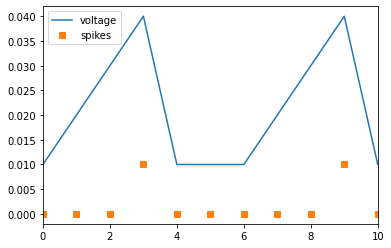

In [16]:
# test of neuron dynamics of input layer
times = np.linspace(0, 10, 11)
IF_trial = IF(10, 'input', n_ref=3)
z_pres = tf.Variable(0.01*np.ones([len(times), IF_trial.n]))
v_history = [IF_trial.v[0]]
z_history = [IF_trial.z[0]]
for i in range(len(times)-1):
    IF_trial(z_pres[i]) # for dynamic function
    v_history.append(IF_trial.v[0])
    z_history.append(IF_trial.z[0])

# ! warning from plot
plt.figure()
plt.plot(times, v_history, label='voltage')
plt.plot(times, 0.01*np.asanyarray(z_history, dtype='float32'), 's', label='spikes')
plt.xlim(0, 10)
plt.legend()
plt.show()

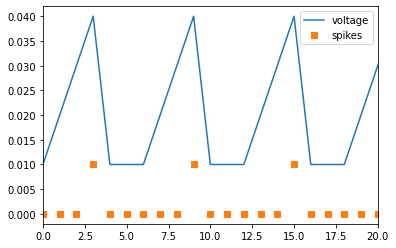

In [17]:
# test of neuron dynamics of input layer
times = np.linspace(0, 100, 101)
IF_trial = IF(10, 'input', n_ref=3)
z_pres = tf.Variable(0.01*np.ones([len(times), IF_trial.n]))
v_history = [IF_trial.v[0]]
z_history = [IF_trial.z[0]]
for i in range(len(times)-1):
    IF_trial(z_pres[i]) # for callable project
    v_history.append(IF_trial.v[0])
    z_history.append(IF_trial.z[0])
    
plt.figure()
plt.plot(times, v_history, label='voltage')
plt.plot(times, 0.01*np.array(z_history), 's', label='spikes')
plt.xlim(0, 20)
plt.legend()
plt.show()

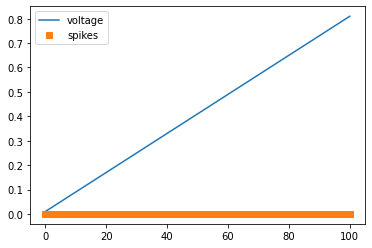

In [18]:
# test for output layer
# voltage should keep increasing and no spike should be emitted
times = np.linspace(0, 100, 101)
IF_trial = IF(10, 'output', n_in=8, n_ref=3)
z_pres = 0.01*np.ones([len(times), IF_trial.n_in])
v_history = [IF_trial.v[0]]
z_history = [IF_trial.z[0]]
for i in range(len(times)-1):
    IF_trial(z_pres[i]) # for callable project
    v_history.append(IF_trial.v[0])
    z_history.append(IF_trial.z[0])
    
plt.figure()
plt.plot(times, v_history, label='voltage')
plt.plot(times, 0.01*np.array(z_history), 's', label='spikes')
plt.legend()
plt.show()

In [19]:
#　leaky integrate-and-fire neuron layer
class LIF(IF):
    def __init__(self, n, type, n_in = None, thr = 0.03, dt = 1.0, n_ref=0, tau_v = 20, w0 = 0.125,
                n_delay = 1, dampening_factor=0.3, injected_noise_current=0., v0 = 0.01):
        super(LIF, self).__init__(n = n, type = type, n_in = n_in, thr = thr, dt = dt, n_ref = n_ref, n_delay = n_delay,
                                w0 = w0, injected_noise_current = injected_noise_current, v0 = v0)
        self.tau_v = tau_v
        self.alpha = np.exp(-self.dt/self.tau_v)
        
    def dynamic(self, z_pre):
        '''
        Function that generate the next spike and voltage tensor.
        Param 
            z_pre: spike train from previous layer of neuron/inputs 
        Return
            self.v: voltages of next time step
            self.z: spikes of next time step
        '''
         # define the current 
        if type(z_pre) != tf.Tensor: 
            z_pre = tf.convert_to_tensor(z_pre)

        if self.type == 'hidden' or self.type == 'output':
            if z_pre.shape != (self.n_in, 1): 
                z_pre = tf.reshape(z_pre, shape = (self.n_in, 1))
        else:
            if z_pre.shape != (self.n, 1): 
                z_pre = tf.reshape(z_pre, shape = (self.n, 1))
        
        if self.type == 'hidden' or self.type == 'output':
            current = tf.linalg.matmul(tf.transpose(self.w_in), z_pre)
        else:
            current = z_pre

        # add random noise to current
        if self.injected_noise_current > 0:
            if self.type == 'input':
                current = current + tf.random.normal(shape=self.n, stddev=self.injected_noise_current)
            elif self.type == 'hidden' or self.type == 'output':
                current = current + tf.random.normal(shape=(self.n_in, self.n), stddev=self.injected_noise_current)
        
        current = tf.reshape(current, shape=(self.n, ))
        
            
        # update the voltage and spike of this layer
        # for input layer:
        if self.type == 'input':
            for i in range(len(self.v)): # for a certain neuron in this layer
                # judge whether to update the voltage or not
                if self.ref_tag[i]==1 and self.ref_time[i] < self.n_ref: # if it's in refractory period and ref_time < n_ref
                    self.ref_time[i] += 1
                    self.v[i] = self.v0
                elif self.ref_tag[i]==1 and self.ref_time[i] == self.n_ref:
                    self.ref_tag[i] = 0
                    self.ref_time[i] = 0
                    self.v[i] = self.v0
                else:
                    self.v[i] = self.alpha * self.v[i] + (1-self.alpha)*current[i]

                # judge if emit spike or not
                if self.v[i] > self.thr[i]:
                    self.z[i] = 1 # emit spike 
                    self.ref_time[i] += 1 # add timer to count the reference time
                    self.ref_tag[i] = 1

                else:
                    self.z[i] = 0

        # for hidden layer
        elif self.type == 'hidden':

            # if not in refractory period
            if self.ref_tag == False:
                v_max = self.v0
                max_index = 0
                # update voltage and get the maximum voltage tag if this layer is fired
                for i in range(len(self.v)):
                    self.v[i] = self.alpha * self.v[i] + (1-self.alpha)*current[i]
                    if self.v[i] > self.thr[i]:
                        self.ref_tag = True
                        if v_max < self.v[i]:
                            v_max = self.v[i]
                            max_index = i

                self.z = np.zeros(self.n)
                if self.ref_tag == True:
                    self.z[max_index] = 1

            elif self.ref_tag == True:
                self.z = np.zeros(self.n)
                self.v = self.v0*np.ones(self.n)
                self.ref_time += 1
                if self.ref_time == self.n_ref:
                    self.ref_tag = False
                    self.ref_time = 0
                    
        # for output layer
        else: 
            self.v = self.alpha * self.v + (1-self.alpha)*current

        return self.v, self.z

In [20]:
times = np.linspace(0, 10, 11)
LIF_trial = LIF(10, 'output', n_in=8, n_ref=3)
z_pres = tf.constant(np.ones([len(times), LIF_trial.n_in]))

loss_func = tf.keras.losses.CategoricalCrossentropy()
y_true = tf.constant(0.08*np.ones(10))

LIF_trial.w_in = tf.Variable(np.random.normal(0, 0.01, [LIF_trial.n_in, LIF_trial.n]), trainable=True)

with tf.GradientTape() as tape:
    for i in range(len(times)-1):
        v_output = LIF_trial(z_pres[i])[0]
        y_pred = tf.nn.softmax(v_output)
        loss = loss_func(y_true, y_pred)

grad_2 = tape.gradient(loss, [LIF_trial.w_in, v_output])
print(grad_2)

[<tf.Tensor: shape=(8, 10), dtype=float64, numpy=
array([[-6.49214888e-04,  7.25075908e-04, -1.32248551e-04,
        -3.36240058e-05, -5.66492098e-05,  4.73978552e-05,
        -2.06202023e-04,  6.41816945e-04,  2.42796014e-04,
        -5.79148044e-04],
       [-6.49214888e-04,  7.25075908e-04, -1.32248551e-04,
        -3.36240058e-05, -5.66492098e-05,  4.73978552e-05,
        -2.06202023e-04,  6.41816945e-04,  2.42796014e-04,
        -5.79148044e-04],
       [-6.49214888e-04,  7.25075908e-04, -1.32248551e-04,
        -3.36240058e-05, -5.66492098e-05,  4.73978552e-05,
        -2.06202023e-04,  6.41816945e-04,  2.42796014e-04,
        -5.79148044e-04],
       [-6.49214888e-04,  7.25075908e-04, -1.32248551e-04,
        -3.36240058e-05, -5.66492098e-05,  4.73978552e-05,
        -2.06202023e-04,  6.41816945e-04,  2.42796014e-04,
        -5.79148044e-04],
       [-6.49214888e-04,  7.25075908e-04, -1.32248551e-04,
        -3.36240058e-05, -5.66492098e-05,  4.73978552e-05,
        -2.06202023e

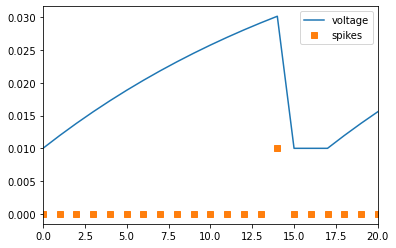

In [21]:
times = np.linspace(0, 100, 101)
LIF_trial = LIF(n=10, type='input', n_ref=3)
z_pres = 0.05*np.ones([len(times), LIF_trial.n])
v_history = [LIF_trial.v[0]]
z_history = [LIF_trial.z[0]]
for i in range(len(times)-1):
    LIF_trial.dynamic(z_pres[i])
    v_history.append(LIF_trial.v[0])
    z_history.append(LIF_trial.z[0])

plt.plot(times, v_history, label='voltage')
plt.plot(times, 0.01*np.array(z_history), 's', label='spikes')
plt.xlim(0, 20)
plt.legend()
plt.show()

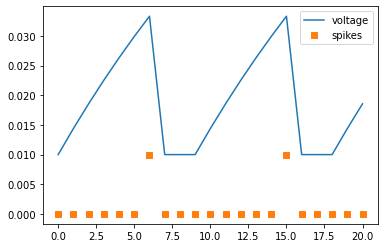

In [22]:
times = np.linspace(0, 20, 21)
LIF_trial = LIF(n=10, type='hidden', n_in=8, n_ref=3)
z_pres = 0.1*np.ones([len(times), LIF_trial.n_in])
v_history = [LIF_trial.v[0]]
z_history = [LIF_trial.z[0]]
for i in range(len(times)-1):
    LIF_trial(z_pres[i])
    if LIF_trial.z[1] != 0:
        print(LIF_trial.z)
        print(LIF_trial.v)
    #print(LIF_trial.v)
    v_history.append(LIF_trial.v[0])
    z_history.append(LIF_trial.z[0])

plt.plot(times, v_history, label='voltage')
plt.plot(times, 0.01*np.array(z_history), 's', label='spikes')
#plt.xlim(0, 20)
plt.legend()
plt.show()

In [23]:
# test for hidden layer
# as w0 doesn't involve in the dynamics of input layer, 
# hidden layer's dynamics should be different from input layer
times = np.linspace(0, 20, 21)
LIF_trial = LIF(10, 'hidden', n_in=8, n_ref=3)
#tf.Variable(w0*np.ones([self.n_in, self.n]), trainable=True)
LIF_trial.w_in = np.random.rand(LIF_trial.n_in, LIF_trial.n)
#v_history = [IF_trial.v[0]]
#z_history = [IF_trial.z[0]]
for i in range(len(times)-1):
    LIF_trial(z_pres[i]) # for callable project
    #v_history.append(IF_trial.v[0])
    #z_history.append(IF_trial.z[0])
    print(LIF_trial.v)
    print(LIF_trial.z)
    if i == 10:
        LIF_trial.w_in += np.random.rand(LIF_trial.n_in, LIF_trial.n)-0.5

[0.03009149 0.02646407 0.0274243  0.03377726 0.02895346 0.03254425
 0.03447322 0.02514319 0.02740688 0.03310318]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.03009149 0.02646407 0.0274243  0.03377726 0.02895346 0.03254425
 0.03447322 0.02514319 0.02740688 0.03310318]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.03009149 0.02646407 0.0274243  0.03377726 0.02895346 0.03254425
 0.03447322 0.02514319 0.02740688 0.03310318]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
[0. 0. 0.

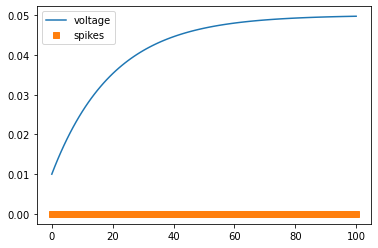

In [24]:
times = np.linspace(0, 100, 101)
LIF_trial = LIF(n=10, type='output', n_in=8, n_ref=3)
z_pres = 0.05*np.ones([len(times), LIF_trial.n_in])
v_history = [LIF_trial.v[0]]
z_history = [LIF_trial.z[0]]
for i in range(len(times)-1):
    LIF_trial(z_pres[i])
    #print(LIF_trial.v)
    v_history.append(LIF_trial.v[0])
    z_history.append(LIF_trial.z[0])

plt.plot(times, v_history, label='voltage')
plt.plot(times, 0.01*np.array(z_history), 's', label='spikes')
plt.legend()
plt.show()

In [25]:
#　Adaptive leaky integrate-and-fire neuron layer
class ALIF(LIF):
    def __init__(self, n, type, n_in = None, thr = 0.03, dt = 1.0, n_ref=0, tau_v = 20, tau_a = 70, w0 = 0.12,
                n_delay = 1, dampening_factor=0.3, injected_noise_current=0., v0 = 0.01, beta=1.8):
        super(ALIF, self).__init__(n = n, type = type, n_in = n_in, thr = thr, dt = dt, n_ref = n_ref, tau_v = tau_v,
                                 n_delay = n_delay, dampening_factor = dampening_factor, w0 = w0,
                                 injected_noise_current = injected_noise_current, v0 = v0)
        self.beta = beta
        self.tau_a = tau_a
        self.rou = np.exp(-self.dt/self.tau_a)
        self.thr_init = thr
        
        
    def dynamic(self, z_pre):
        '''
        Function that generate the next spike and voltage tensor.
        Parameters:
            z_pre: spike train from previous layer of neuron/inputs 
        Returns:
            self.v: voltages of next time step
            self.z: spikes of next time step
            self.thr_list: thresholds of next time step
        '''
        # define the current 
        if type(z_pre) != tf.Tensor: 
            z_pre = tf.convert_to_tensor(z_pre)

        if self.type == 'hidden' or self.type == 'output':
            if z_pre.shape != (self.n_in, 1): 
                z_pre = tf.reshape(z_pre, shape = (self.n_in, 1))
        else:
            if z_pre.shape != (self.n, 1): 
                z_pre = tf.reshape(z_pre, shape = (self.n, 1))
        
        if self.type == 'hidden' or self.type == 'output':
            current = tf.linalg.matmul(tf.transpose(self.w_in), z_pre)
        else:
            current = z_pre

        # add random noise to current
        if self.injected_noise_current > 0:
            if self.type == 'input':
                current = current + tf.random.normal(shape=self.n, stddev=self.injected_noise_current)
            elif self.type == 'hidden' or self.type == 'output':
                current = current + tf.random.normal(shape=(self.n_in, self.n), stddev=self.injected_noise_current)
        
        current = tf.reshape(current, shape=(self.n, ))
        
            
        # update the voltage, threshold and spike of this layer
        if self.type == 'input':
            for i in range(len(self.v)): # for a certain neuron in this layer
                # judge whether to update the voltage or not
                if self.ref_tag[i]==1 and self.ref_time[i] < self.n_ref: # if it's in refractory period and ref_time < n_ref
                    self.ref_time[i] += 1
                    self.v[i] = self.v0
                elif self.ref_tag[i]==1 and self.ref_time[i] == self.n_ref:
                    self.ref_tag[i] = 0
                    self.ref_time[i] = 0
                    self.v[i] = self.v0
                else:
                    self.v[i] = self.alpha * self.v[i] + (1-self.alpha)*current[i]

                # judge if emit spike or not
                if self.v[i] > self.thr[i]:
                    self.z[i] = 1 # emit spike 
                    self.ref_time[i] += 1 # add timer to count the reference time
                    self.ref_tag[i] = 1

                else:
                    self.z[i] = 0

            # update threshold
            self.thr = self.thr_init + self.beta*(self.rou*self.thr+(1-self.rou)*self.z)*self.v0

        
        # for hidden layer
        elif self.type == 'hidden':

            # if not in refractory period
            if self.ref_tag == False:
                v_max = self.v0
                max_index = 0
                # update voltage and get the maximum voltage tag if this layer is fired
                for i in range(len(self.v)):
                    self.v[i] = self.alpha * self.v[i] + (1-self.alpha)*current[i]
                    if self.v[i] > self.thr[i]:
                        self.ref_tag = True
                        if v_max < self.v[i]:
                            v_max = self.v[i]
                            max_index = i

                self.z = np.zeros(self.n)
                if self.ref_tag == True:
                    self.z[max_index] = 1

            elif self.ref_tag == True:
                self.z = np.zeros(self.n)
                self.v = self.v0*np.ones(self.n)
                self.ref_time += 1
                if self.ref_time == self.n_ref:
                    self.ref_tag = False
                    self.ref_time = 0

            # update threshold
            self.thr = self.thr_init + self.beta*(self.rou*self.thr+(1-self.rou)*self.z)*self.v0
            
        else:
            self.v = self.alpha * self.v + (1-self.alpha)*current


        return self.v, self.z, self.thr

    def __call__(self, z_pre):
        v, z, _ = self.dynamic(z_pre)
        return v, z


In [26]:
times = np.linspace(0, 100, 101)
ALIF_trial = ALIF(10, 'output', n_in=8, n_ref=3)
z_pres = tf.constant(np.ones([len(times), ALIF_trial.n_in]))

loss_func = tf.keras.losses.CategoricalCrossentropy()
y_true = tf.constant(0.08*np.ones(10))

ALIF_trial.w_in = tf.Variable(np.random.normal(0, 0.01, [ALIF_trial.n_in, ALIF_trial.n]), trainable=True)

with tf.GradientTape() as tape:
    for i in range(len(times)-1):
        v_output = ALIF_trial(z_pres[i])[0]
        y_pred = tf.nn.softmax(v_output)
        loss = loss_func(y_true, y_pred)

grad_2 = tape.gradient(loss, [ALIF_trial.w_in, v_output])
print(grad_2)

[<tf.Tensor: shape=(8, 10), dtype=float64, numpy=
array([[-0.00349105,  0.00493997, -0.00035512, -0.00750691,  0.00230768,
        -0.00206951,  0.0025625 , -0.00043551,  0.00151188,  0.00253608],
       [-0.00349105,  0.00493997, -0.00035512, -0.00750691,  0.00230768,
        -0.00206951,  0.0025625 , -0.00043551,  0.00151188,  0.00253608],
       [-0.00349105,  0.00493997, -0.00035512, -0.00750691,  0.00230768,
        -0.00206951,  0.0025625 , -0.00043551,  0.00151188,  0.00253608],
       [-0.00349105,  0.00493997, -0.00035512, -0.00750691,  0.00230768,
        -0.00206951,  0.0025625 , -0.00043551,  0.00151188,  0.00253608],
       [-0.00349105,  0.00493997, -0.00035512, -0.00750691,  0.00230768,
        -0.00206951,  0.0025625 , -0.00043551,  0.00151188,  0.00253608],
       [-0.00349105,  0.00493997, -0.00035512, -0.00750691,  0.00230768,
        -0.00206951,  0.0025625 , -0.00043551,  0.00151188,  0.00253608],
       [-0.00349105,  0.00493997, -0.00035512, -0.00750691,  0.00230

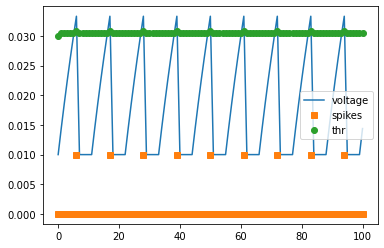

In [27]:
times = np.linspace(0, 100, 101)
ALIF_trial = ALIF(n=10, type='input', n_ref=5, beta=1.8)
z_pres = 0.1*np.ones([len(times), ALIF_trial.n])
v_history = [ALIF_trial.v[0]]
z_history = [ALIF_trial.z[0]]
thr_history = [ALIF_trial.thr[0]]
for i in range(len(times)-1):
    ALIF_trial.dynamic(z_pres[i])
    v_history.append(ALIF_trial.v[0])
    z_history.append(ALIF_trial.z[0])
    thr_history.append(ALIF_trial.thr[0])

plt.plot(times, v_history, label='voltage')
plt.plot(times, 0.01*np.array(z_history), 's', label='spikes')
plt.plot(times, np.array(thr_history), 'o', label='thr')
#plt.xlim(0, 20)
plt.legend()
plt.show()

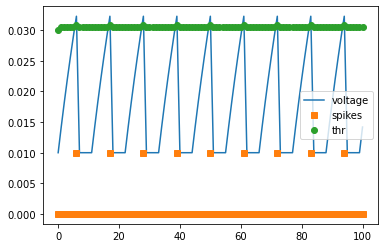

In [28]:
times = np.linspace(0, 100, 101)
ALIF_trial = ALIF(n=10, type='hidden', n_ref=5, n_in=8, beta=1.8)
z_pres = 0.1*np.ones([len(times), ALIF_trial.n_in])
v_history = [ALIF_trial.v[0]]
z_history = [ALIF_trial.z[0]]
thr_history = [ALIF_trial.thr[0]]
for i in range(len(times)-1):
    ALIF_trial.dynamic(z_pres[i])
    v_history.append(ALIF_trial.v[0])
    z_history.append(ALIF_trial.z[0])
    thr_history.append(ALIF_trial.thr[0])

plt.plot(times, v_history, label='voltage')
plt.plot(times, 0.01*np.array(z_history), 's', label='spikes')
plt.plot(times, np.array(thr_history), 'o', label='thr')
#plt.xlim(0, 20)
plt.legend()
plt.show()

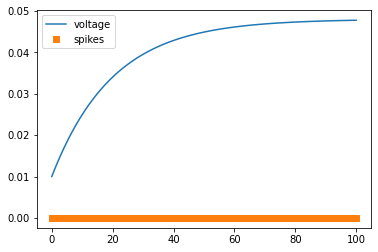

In [29]:
times = np.linspace(0, 100, 101)
ALIF_trial = ALIF(n=10, type='output', n_in=8, n_ref=3)
z_pres = 0.05*np.ones([len(times), ALIF_trial.n_in])
v_history = [ALIF_trial.v[0]]
z_history = [ALIF_trial.z[0]]
for i in range(len(times)-1):
    v, z = ALIF_trial(z_pres[i])
    v_history.append(v[0])
    z_history.append(z[0])

plt.plot(times, v_history, label='voltage')
plt.plot(times, 0.01*np.array(z_history), 's', label='spikes')
plt.legend()
plt.show()

**Recurrent layer objects**

In [30]:
Cell_reccurent = tf.keras.layers.AbstractRNNCell

# integrate-and-fire neuron layer (recurrent)
class IF_recurrent(Cell_reccurent):
    def __init__(self, n, type, n_in = None, thr = 0.03, dt = 1.0, n_ref = 2,
        n_delay = 1, injected_noise_current=0., v0 = 0.01, w0_in = 0.1, w0_rec = 0.1):
        '''
        Initialize the integrate-and-fire (IF) neuron layer object.
        Parameters:
            n: number of neuron in this layer
            type: input/hidden/output
            n_in: number of neuron in the previous layer
            thr: threshold voltage of IF neuron
            dt: timestep for voltage update in ms
            n_ref: number of refractory timestep
            n_delay: number of delay timestep
            dampening_factor: dampening_factor used in pseud-gradient during BPTT
            injected_noise_current: noise current from hardware/variance of hardware
            v0: value of initial membrane voltage
            w0: value of initial weight
        '''
        self.n = n 
        self.thr = thr*np.ones([self.n])
        self.dt = dt
        self.n_ref = n_ref
        self.n_delay = n_delay
        self.injected_noise_current = injected_noise_current # can be used to simulate the device noise/variation
        assert (v0 < thr), "Static voltage should be smaller the threshold!"
        self.type = type
        self.v0 = v0
        self.v = self.v0 * np.ones(self.n) # self.v - an array of # self.n that contain the membrane voltage of this layer
        self.z = np.zeros(self.n) # self.z - an array of # self.n that contain possible spikes of this layer
        self.w_rec = tf.Variable(w0_rec*np.ones(self.n), trainable=True) # initiate the recurrent weights

        if self.type == 'input':
            self.ref_time = np.zeros(self.n)
            self.ref_tag = np.zeros(self.n) # defualt is not in refractory state
        elif self.type == 'hidden':
            if n_in != None:
                assert(n_in >= 0), "For hidden layer, the number of input neuron should be larger than 0!"
                self.ref_time = 0
                self.n_in = n_in
                self.w_in = tf.Variable(w0_in*np.ones([self.n_in, self.n]), trainable=True)
                self.ref_tag = False # to record if a neuron is fired in a certain timestep or not for lateral inhibition
            else:
                raise ValueError("Hidden layer should have specific neuron from previous layer!")
        elif self.type == 'output':
            if n_in != None:
                assert(n_in >= 0), "For output layer, the number of input neuron should be larger than 0!"
                self.n_in = n_in
                self.w_in = tf.Variable(w0_in*np.ones([self.n_in, self.n]), trainable=True)
            else:
                raise ValueError("Output layer should have specific neuron from previous layer!")
        else:
            raise TypeError("Type should be among input/hidden/output!")


    def dynamic(self, z_pre):
        """
        Function that generate the next spike and voltage tensor for 1 timestep.
        Parameters:
            z_pre: spike train from previous layer of neuron/inputs 
        Returns:
            self.v: voltages of next time step
            self.z: spikes of next time step
        """
        # define the current 
        if type(z_pre) != tf.Tensor: 
            z_pre = tf.convert_to_tensor(z_pre)

        if self.type == 'hidden' or self.type == 'output':
            if z_pre.shape != (self.n_in, 1): 
                z_pre = tf.reshape(z_pre, shape = (self.n_in, 1))
        else:
            if z_pre.shape != (self.n, 1): 
                z_pre = tf.reshape(z_pre, shape = (self.n, ))

        #print(tf.reshape(tf.Variable(self.z), shape=(10, 1)))
        
        if self.type == 'hidden' or self.type == 'output':
            current = tf.linalg.matmul(tf.transpose(self.w_in), z_pre) + \
                tf.reshape(self.w_rec, shape=(self.n, 1)).numpy() * tf.reshape(tf.Variable(self.z), shape=(self.n, 1)).numpy()
        else:
            current = z_pre + self.z

        # add random noise to current
        if self.injected_noise_current > 0:
            if self.type == 'input':
                current = current + tf.random.normal(shape=self.n, stddev=self.injected_noise_current)
            elif self.type == 'hidden' or self.type == 'output':
                current = current + tf.random.normal(shape=(self.n_in, self.n), stddev=self.injected_noise_current)
        

        current = tf.reshape(current, shape=(self.n, ))

        # for input layer
        if self.type == 'input':
            for i in range(len(self.v)): # for a certain neuron in this layer
                # judge whether to update the voltage or not
                if self.ref_tag[i]==1 and self.ref_time[i] < self.n_ref: # if it's in refractory period and ref_time < n_ref
                    self.ref_time[i] += 1
                    self.v[i] = self.v0
                elif self.ref_tag[i]==1 and self.ref_time[i] == self.n_ref:
                    self.ref_tag[i] = 0
                    self.ref_time[i] = 0
                    self.v[i] = self.v0
                else:
                    self.v[i] = self.v[i] + current[i]

                # judge if emit spike or not
                if self.v[i] > self.thr[i]:
                    self.z[i] = 1 # emit spike 
                    self.ref_time[i] += 1 # add timer to count the reference time
                    self.ref_tag[i] = 1

                else:
                    self.z[i] = 0

        # for hidden layer
        elif self.type == 'hidden':
            # if not in refractory period
            if self.ref_tag == False:
                v_max = self.v0
                max_index = 0
                # update voltage and get the maximum voltage tag if this layer is fired
                for i in range(len(self.v)):
                    self.v[i] = self.v[i] + current[i]
                    if self.v[i] > self.thr[i]:
                        self.ref_tag = True
                        if v_max < self.v[i]:
                            v_max = self.v[i]
                            max_index = i

                self.z = np.zeros(self.n)
                if self.ref_tag == True:
                    self.z[max_index] = 1

            elif self.ref_tag == True:
                self.z = np.zeros(self.n)
                self.v = self.v0*np.ones(self.n)
                self.ref_time += 1
                if self.ref_time == self.n_ref:
                    self.ref_tag = False
                    self.ref_time = 0

        # for output layer - voltage should change continuously and no spike should be emitted
        else:
            self.v = self.v + current
    
        return self.v, self.z

    def __call__(self, z_pre):
        '''
        Turn the object into a callable project with emitted spikes
        '''
        v, z = self.dynamic(z_pre)
        return v, z

    def get_current_v(self):
        '''
        Return the membrane voltage of this layer of IF neuron
        '''
        return self.v

    def get_current_z(self):
        '''
        Return the spike array of this layer of IF neuron
        '''
        return self.z

In [31]:
times = np.linspace(0, 100, 101)
IF_trial = IF_recurrent(10, 'output', n_in=8, n_ref=3)
z_pres = tf.constant(np.ones([len(times), IF_trial.n_in]))

loss_func = tf.keras.losses.CategoricalCrossentropy()
y_true = tf.constant(0.08*np.ones(10))

IF_trial.w_in = tf.Variable(np.random.normal(0, 0.01, [IF_trial.n_in, IF_trial.n]), trainable=True)

with tf.GradientTape() as tape:
    for i in range(len(times)-1):
        v_output = IF_trial(z_pres[i])[0]
        y_pred = tf.nn.softmax(v_output)
        loss = loss_func(y_true, y_pred)

grad_2 = tape.gradient(loss, [IF_trial.w_in, v_output])
print(grad_2)

[<tf.Tensor: shape=(8, 10), dtype=float64, numpy=
array([[-7.99831806,  0.30789923, -7.85651902, 58.36000115, -7.87616722,
        -4.81283876, -6.19501016, -7.9968323 , -7.97749598, -7.95471888],
       [-7.99831806,  0.30789923, -7.85651902, 58.36000115, -7.87616722,
        -4.81283876, -6.19501016, -7.9968323 , -7.97749598, -7.95471888],
       [-7.99831806,  0.30789923, -7.85651902, 58.36000115, -7.87616722,
        -4.81283876, -6.19501016, -7.9968323 , -7.97749598, -7.95471888],
       [-7.99831806,  0.30789923, -7.85651902, 58.36000115, -7.87616722,
        -4.81283876, -6.19501016, -7.9968323 , -7.97749598, -7.95471888],
       [-7.99831806,  0.30789923, -7.85651902, 58.36000115, -7.87616722,
        -4.81283876, -6.19501016, -7.9968323 , -7.97749598, -7.95471888],
       [-7.99831806,  0.30789923, -7.85651902, 58.36000115, -7.87616722,
        -4.81283876, -6.19501016, -7.9968323 , -7.97749598, -7.95471888],
       [-7.99831806,  0.30789923, -7.85651902, 58.36000115, -7.87616

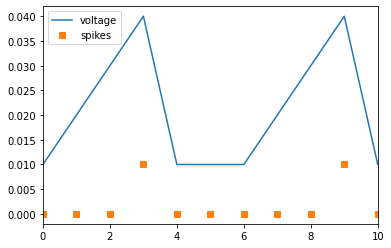

In [32]:
times = np.linspace(0, 10, 11)
IF_trial = IF_recurrent(12, 'input', n_ref=3)
z_pres = 0.01*np.ones([len(times), IF_trial.n])
v_history = [IF_trial.v[0]]
z_history = [IF_trial.z[0]]
for i in range(len(times)-1):
    IF_trial.dynamic(z_pres[i])
    #print(IF_trial.z[0])
    v_history.append(IF_trial.v[0])
    z_history.append(IF_trial.z[0])
    
plt.figure()
plt.plot(times, v_history, label='voltage')
plt.plot(times, 0.01*np.array(z_history), 's', label='spikes')
plt.xlim(0, 10)
plt.legend()
plt.show()

In [33]:
# test for hidden layer
# as w0 doesn't involve in the dynamics of input layer, 
# hidden layer's dynamics should be different from input layer
times = np.linspace(0, 20, 21)
IF_trial = IF_recurrent(10, 'hidden', n_in=8, n_ref=3)
#tf.Variable(w0*np.ones([self.n_in, self.n]), trainable=True)
IF_trial.w_in = np.random.rand(IF_trial.n_in, IF_trial.n)
z_pres = 0.01*np.ones([len(times), IF_trial.n_in])
#v_history = [IF_trial.v[0]]
#z_history = [IF_trial.z[0]]
for i in range(len(times)-1):
    IF_trial(z_pres[i]) # for callable project
    #v_history.append(IF_trial.v[0])
    #z_history.append(IF_trial.z[0])
    print(IF_trial.v)
    print(IF_trial.z)
    if i == 10:
        IF_trial.w_in += np.random.rand(IF_trial.n_in, IF_trial.n)-0.5

    
#plt.figure()
#plt.plot(times, v_history, label='voltage')
#plt.plot(times, 0.01*np.array(z_history), 's', label='spikes')
#plt.xlim(0, 10)
#plt.legend()
#plt.show()

[0.03422698 0.04848462 0.04254421 0.04205615 0.04708585 0.05552465
 0.05531068 0.05868376 0.03299235 0.06766263]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.03422698 0.04848462 0.04254421 0.04205615 0.04708585 0.05552465
 0.05531068 0.05868376 0.03299235 0.06766263]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.03422698 0.04848462 0.04254421 0.04205615 0.04708585 0.05552465
 0.05531068 0.05868376 0.03299235 0.06766263]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
[0. 0. 0.

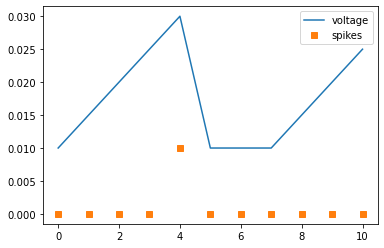

In [34]:
times = np.linspace(0, 10, 11)
IF_trial = IF_recurrent(10, 'hidden', n_in=5, n_ref=3)
z_pres = 0.01*np.ones([len(times), IF_trial.n_in])
v_history = [IF_trial.v[0]]
z_history = [IF_trial.z[0]]
for i in range(len(times)-1):
    IF_trial.dynamic(z_pres[i])
    v_history.append(IF_trial.v[0])
    z_history.append(IF_trial.z[0])
    
plt.figure()
plt.plot(times, v_history, label='voltage')
plt.plot(times, 0.01*np.array(z_history), 's', label='spikes')
#plt.xlim(0, 10)
plt.legend()
plt.show()

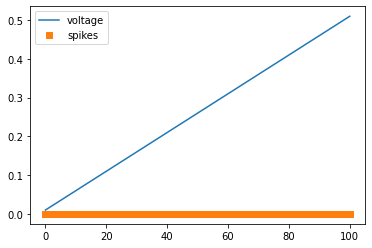

In [35]:
times = np.linspace(0, 100, 101)
IF_trial = IF_recurrent(10, 'output', n_in=5, n_ref=3)
z_pres = 0.01*np.ones([len(times), IF_trial.n_in])
v_history = [IF_trial.v[0]]
z_history = [IF_trial.z[0]]
for i in range(len(times)-1):
    IF_trial.dynamic(z_pres[i])
    #print(IF_trial.z[0])
    v_history.append(IF_trial.v[0])
    z_history.append(IF_trial.z[0])
    
plt.figure()
plt.plot(times, v_history, label='voltage')
plt.plot(times, 0.01*np.array(z_history), 's', label='spikes')
#plt.xlim(0, 20)
plt.legend()
plt.show()

In [36]:
#　leaky integrate-and-fire neuron layer (recurrent)
class LIF_recurrent(IF_recurrent):
    def __init__(self, n, type, n_in = None, thr = 0.03, dt = 1.0, n_ref=0, tau_v = 20, w0_in = 0.2, 
                w0_rec = 0.2, n_delay = 1, injected_noise_current=0., v0 = 0.01):
        super(LIF_recurrent, self).__init__(n = n, type = type, n_in = n_in, thr = thr, dt = dt, n_ref = n_ref, 
                                 n_delay = n_delay, w0_in = w0_in,
                                 w0_rec = w0_rec, injected_noise_current = injected_noise_current, v0 = v0)
        self.tau_v = tau_v
        self.alpha = np.exp(-self.dt/self.tau_v)
        
    def dynamic(self, z_pre):
        '''
        Function that generate the next spike and voltage tensor.
        Param 
            z_pre: spike train from previous layer of neuron/inputs 
        Return
            self.v: voltages of next time step
            self.z: spikes of next time step
        '''
        # define the current 
        if type(z_pre) != tf.Tensor: 
            z_pre = tf.convert_to_tensor(z_pre)

        if self.type == 'hidden' or self.type == 'output':
            if z_pre.shape != (self.n_in, 1): 
                z_pre = tf.reshape(z_pre, shape = (self.n_in, 1))
        else:
            if z_pre.shape != (self.n, 1): 
                z_pre = tf.reshape(z_pre, shape = (self.n, ))
        
        if self.type == 'hidden' or self.type == 'output':
            current = tf.linalg.matmul(tf.transpose(self.w_in), z_pre) + \
                tf.reshape(self.w_rec, shape=(self.n, 1)).numpy() * tf.reshape(tf.Variable(self.z), shape=(self.n, 1)).numpy()
        else:
            current = z_pre + self.z


        # add random noise to current
        if self.injected_noise_current > 0:
            if self.type == 'input':
                current = current + tf.random.normal(shape=self.n, stddev=self.injected_noise_current)
            elif self.type == 'hidden' or self.type == 'output':
                current = current + tf.random.normal(shape=(self.n_in, self.n), stddev=self.injected_noise_current)
        

        current = tf.reshape(current, shape=(self.n, ))
        
            
        # update the voltage and spike of this layer
        # for input layer
        if self.type == 'input':
            for i in range(len(self.v)): # for a certain neuron in this layer
                # judge whether to update the voltage or not
                if self.ref_tag[i]==1 and self.ref_time[i] < self.n_ref: # if it's in refractory period and ref_time < n_ref
                    self.ref_time[i] += 1
                    self.v[i] = self.v0
                elif self.ref_tag[i]==1 and self.ref_time[i] == self.n_ref:
                    self.ref_tag[i] = 0
                    self.ref_time[i] = 0
                    self.v[i] = self.v0
                else:
                    self.v[i] = self.alpha*self.v[i] + (1-self.alpha)*current[i]

                # judge if emit spike or not
                if self.v[i] > self.thr[i]:
                    self.z[i] = 1 # emit spike 
                    self.ref_time[i] += 1 # add timer to count the reference time
                    self.ref_tag[i] = 1

                else:
                    self.z[i] = 0
        
        # for hidden layer
        elif self.type == 'hidden':
            # if not in refractory period
            if self.ref_tag == False:
                v_max = self.v0
                max_index = 0
                # update voltage and get the maximum voltage tag if this layer is fired
                for i in range(len(self.v)):
                    self.v[i] = self.alpha*self.v[i] + (1-self.alpha)*current[i]
                    if self.v[i] > self.thr[i]:
                        self.ref_tag = True
                        if v_max < self.v[i]:
                            v_max = self.v[i]
                            max_index = i

                self.z = np.zeros(self.n)
                if self.ref_tag == True:
                    self.z[max_index] = 1

            elif self.ref_tag == True:
                self.z = np.zeros(self.n)
                self.v = self.v0*np.ones(self.n)
                self.ref_time += 1
                if self.ref_time == self.n_ref:
                    self.ref_tag = False
                    self.ref_time = 0

        # for output layer
        else:
            self.v = self.alpha * self.v + (1-self.alpha)*current

        return self.v, self.z

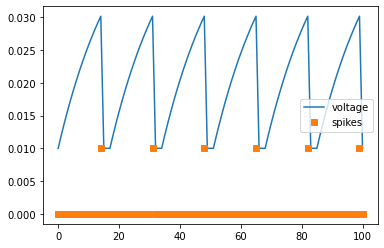

In [37]:
times = np.linspace(0, 100, 101)
LIF_trial = LIF_recurrent(n=10, type='input', n_ref=3)
z_pres = 0.05*np.ones([len(times), LIF_trial.n])
v_history = [LIF_trial.v[0]]
z_history = [LIF_trial.z[0]]
for i in range(len(times)-1):
    LIF_trial.dynamic(z_pres[i])
    #print(LIF_trial.v)
    v_history.append(LIF_trial.v[0])
    z_history.append(LIF_trial.z[0])

plt.plot(times, v_history, label='voltage')
plt.plot(times, 0.01*np.array(z_history), 's', label='spikes')
#plt.xlim(0, 20)
plt.legend()
plt.show()

In [38]:
times = np.linspace(0, 100, 101)
LIF_trial = LIF_recurrent(10, 'output', n_in=8, n_ref=3)
z_pres = tf.constant(np.ones([len(times), LIF_trial.n_in]))

loss_func = tf.keras.losses.CategoricalCrossentropy()
y_true = tf.constant(0.08*np.ones(10))

LIF_trial.w_in = tf.Variable(np.random.normal(0, 0.01, [LIF_trial.n_in, LIF_trial.n]), trainable=True)

with tf.GradientTape() as tape:
    for i in range(len(times)-1):
        v_output = LIF_trial(z_pres[i])[0]
        y_pred = tf.nn.softmax(v_output)
        loss = loss_func(y_true, y_pred)

grad_2 = tape.gradient(loss, [LIF_trial.w_in, v_output])
print(grad_2)

[<tf.Tensor: shape=(8, 10), dtype=float64, numpy=
array([[-0.00222116, -0.00018469, -0.00077706, -0.00206206, -0.00291263,
         0.0064635 , -0.00163706, -0.00261733,  0.002423  ,  0.0035255 ],
       [-0.00222116, -0.00018469, -0.00077706, -0.00206206, -0.00291263,
         0.0064635 , -0.00163706, -0.00261733,  0.002423  ,  0.0035255 ],
       [-0.00222116, -0.00018469, -0.00077706, -0.00206206, -0.00291263,
         0.0064635 , -0.00163706, -0.00261733,  0.002423  ,  0.0035255 ],
       [-0.00222116, -0.00018469, -0.00077706, -0.00206206, -0.00291263,
         0.0064635 , -0.00163706, -0.00261733,  0.002423  ,  0.0035255 ],
       [-0.00222116, -0.00018469, -0.00077706, -0.00206206, -0.00291263,
         0.0064635 , -0.00163706, -0.00261733,  0.002423  ,  0.0035255 ],
       [-0.00222116, -0.00018469, -0.00077706, -0.00206206, -0.00291263,
         0.0064635 , -0.00163706, -0.00261733,  0.002423  ,  0.0035255 ],
       [-0.00222116, -0.00018469, -0.00077706, -0.00206206, -0.00291

In [39]:
# test for hidden layer
# as w0 doesn't involve in the dynamics of input layer, 
# hidden layer's dynamics should be different from input layer
times = np.linspace(0, 30, 31)
LIF_trial = LIF_recurrent(10, 'hidden', n_in=8, n_ref=3)
#tf.Variable(w0*np.ones([self.n_in, self.n]), trainable=True)
LIF_trial.w_in = np.random.rand(LIF_trial.n_in, LIF_trial.n)
z_pres = 0.05*np.ones([len(times), LIF_trial.n_in])
#v_history = [IF_trial.v[0]]
#z_history = [IF_trial.z[0]]
for i in range(len(times)-1):
    LIF_trial(z_pres[i]) # for callable project
    #v_history.append(IF_trial.v[0])
    #z_history.append(IF_trial.z[0])
    print(LIF_trial.v)
    print(LIF_trial.z)
    if i%5 == 0:
        LIF_trial.w_in += np.random.rand(LIF_trial.n_in, LIF_trial.n)-0.5

[0.01844451 0.02155157 0.01947626 0.02037341 0.01962879 0.01997273
 0.01745605 0.01846863 0.01808756 0.01969139]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.02796605 0.03050511 0.02801792 0.03165328 0.0283794  0.02749873
 0.02308983 0.02474774 0.02527902 0.02868277]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.01993339 0.01951692 0.01900382 0.02178579 0.01922021 0.01801238
 0.01599742 0.01669214 0.01758589 0.01946403]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.03087147 0.03020954 0.02506333 0.03267327 0.02838353 0.02355257
 0.0217365  0.02467305 0.02312555 0.02890964]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


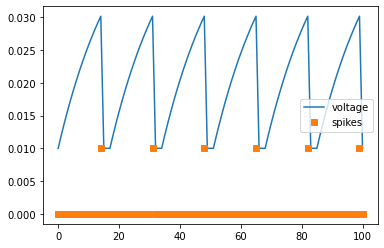

In [40]:
times = np.linspace(0, 100, 101)
LIF_trial = LIF_recurrent(n=10, type='hidden', n_in=5, n_ref=3)
z_pres = 0.05*np.ones([len(times), LIF_trial.n_in])
v_history = [LIF_trial.v[0]]
z_history = [LIF_trial.z[0]]
for i in range(len(times)-1):
    LIF_trial.dynamic(z_pres[i])
    #print(LIF_trial.v)
    v_history.append(LIF_trial.v[0])
    z_history.append(LIF_trial.z[0])

plt.plot(times, v_history, label='voltage')
plt.plot(times, 0.01*np.array(z_history), 's', label='spikes')
#plt.xlim(0, 20)
plt.legend()
plt.show()

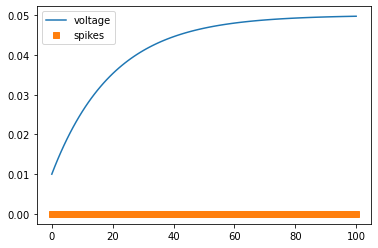

In [41]:
times = np.linspace(0, 100, 101)
LIF_trial = LIF_recurrent(n=10, type='output', n_in=5, n_ref=3)
z_pres = 0.05*np.ones([len(times), LIF_trial.n_in])
v_history = [LIF_trial.v[0]]
z_history = [LIF_trial.z[0]]
for i in range(len(times)-1):
    LIF_trial.dynamic(z_pres[i])
    #print(LIF_trial.v)
    v_history.append(LIF_trial.v[0])
    z_history.append(LIF_trial.z[0])

plt.plot(times, v_history, label='voltage')
plt.plot(times, 0.01*np.array(z_history), 's', label='spikes')
#plt.xlim(0, 20)
plt.legend()
plt.show()

In [42]:
#　Adaptive leaky integrate-and-fire neuron layer (recurrent)
class ALIF_recurrent(LIF_recurrent):
    def __init__(self, n, type, n_in = None, thr = 0.03, dt = 1.0, n_ref=0, tau_v = 20, tau_a = 700, w0_in = 0.2,
               w0_rec = 0.1, n_delay = 1, injected_noise_current=0., v0 = 0.01, beta=1.8):
        super(ALIF_recurrent, self).__init__(n = n, type = type, n_in = n_in, thr = thr, dt = dt, n_ref = n_ref, tau_v = tau_v,
                                 n_delay = n_delay, w0_in = w0_in,
                                 w0_rec = w0_rec, injected_noise_current = injected_noise_current, v0 = v0)
        self.beta = beta
        self.tau_a = tau_a
        self.rou = np.exp(-self.dt/self.tau_a)
        self.thr_init = thr
        
        
    def dynamic(self, z_pre):
        '''
        Function that generate the next spike and voltage tensor.
        Param 
            z_pre: spike train from previous layer of neuron/inputs 
        Return
            self.v: voltages of next time step
            self.z: spikes of next time step
            self.thr_list: thresholds of next time step
        '''
        # define the current 
        if type(z_pre) != tf.Tensor: 
            z_pre = tf.convert_to_tensor(z_pre)

        if self.type == 'hidden' or self.type == 'output':
            if z_pre.shape != (self.n_in, 1): 
                z_pre = tf.reshape(z_pre, shape = (self.n_in, 1))
        else:
            if z_pre.shape != (self.n, 1): 
                z_pre = tf.reshape(z_pre, shape = (self.n, ))

        #print(tf.reshape(tf.Variable(self.z), shape=(10, 1)))
        
        if self.type == 'hidden' or self.type == 'output':
            current = tf.linalg.matmul(tf.transpose(self.w_in), z_pre) + \
                tf.reshape(self.w_rec, shape=(self.n, 1)).numpy() * tf.reshape(tf.Variable(self.z), shape=(self.n, 1)).numpy()
        else:
            current = z_pre + self.z

        # add random noise to current
        if self.injected_noise_current > 0:
            if self.type == 'input':
                current = current + tf.random.normal(shape=self.n, stddev=self.injected_noise_current)
            elif self.type == 'hidden' or self.type == 'output':
                current = current + tf.random.normal(shape=(self.n_in, self.n), stddev=self.injected_noise_current)

        current = tf.reshape(current, shape=(self.n, ))
        
            
        # update the voltage, threshold and spike of this layer
        if self.type == 'input':
            for i in range(len(self.v)): # for a certain neuron in this layer
                # judge whether to update the voltage or not
                if self.ref_tag[i]==1 and self.ref_time[i] < self.n_ref: # if it's in refractory period and ref_time < n_ref
                    self.ref_time[i] += 1
                    self.v[i] = self.v0
                elif self.ref_tag[i]==1 and self.ref_time[i] == self.n_ref:
                    self.ref_tag[i] = 0
                    self.ref_time[i] = 0
                    self.v[i] = self.v0
                else:
                    self.v[i] = self.alpha * self.v[i] + (1-self.alpha)*current[i]

                # judge if emit spike or not
                if self.v[i] > self.thr[i]:
                    self.z[i] = 1 # emit spike 
                    self.ref_time[i] += 1 # add timer to count the reference time
                    self.ref_tag[i] = 1

                else:
                    self.z[i] = 0

            # update threshold
            self.thr = self.thr_init + self.beta*(self.rou*self.thr+(1-self.rou)*self.z)*self.v0

        # for hidden layer
        elif self.type == 'hidden':
            # if not in refractory period
            if self.ref_tag == False:
                v_max = self.v0
                max_index = 0
                # update voltage and get the maximum voltage tag if this layer is fired
                for i in range(len(self.v)):
                    self.v[i] = self.alpha*self.v[i] + (1-self.alpha)*current[i]
                    if self.v[i] > self.thr[i]:
                        self.ref_tag = True
                        if v_max < self.v[i]:
                            v_max = self.v[i]
                            max_index = i

                self.z = np.zeros(self.n)
                if self.ref_tag == True:
                    self.z[max_index] = 1

            elif self.ref_tag == True:
                self.z = np.zeros(self.n)
                self.v = self.v0*np.ones(self.n)
                self.ref_time += 1
                if self.ref_time == self.n_ref:
                    self.ref_tag = False
                    self.ref_time = 0

            # update threshold
            self.thr = self.thr_init + self.beta*(self.rou*self.thr+(1-self.rou)*self.z)*self.v0
      
        else:
            self.v = self.alpha * self.v + (1-self.alpha)*current

        return self.v, self.z, self.thr


    def __call__(self, z_pre):
        '''
        Turn the object into a callable project with emitted spikes
        '''
        v, z, _ = self.dynamic(z_pre)
        return v, z

In [43]:
times = np.linspace(0, 100, 101)
ALIF_trial = IF(10, 'output', n_in=8, n_ref=3)
z_pres = tf.constant(np.ones([len(times), ALIF_trial.n_in]))

loss_func = tf.keras.losses.CategoricalCrossentropy()
y_true = tf.constant(0.08*np.ones(10))

ALIF_trial.w_in = tf.Variable(np.random.normal(0, 0.01, [ALIF_trial.n_in, ALIF_trial.n]), trainable=True)

with tf.GradientTape() as tape:
    for i in range(len(times)-1):
        v_output = ALIF_trial(z_pres[i])[0]
        y_pred = tf.nn.softmax(v_output)
        loss = loss_func(y_true, y_pred)

grad_2 = tape.gradient(loss, [ALIF_trial.w_in, v_output])
print(grad_2)

[<tf.Tensor: shape=(8, 10), dtype=float64, numpy=
array([[-7.24303595, -7.99042327, -7.89880682, -7.89951988, -7.93848355,
        -7.42422944, 40.68060916, -7.82377735,  4.40345788,  9.13420922],
       [-7.24303595, -7.99042327, -7.89880682, -7.89951988, -7.93848355,
        -7.42422944, 40.68060916, -7.82377735,  4.40345788,  9.13420922],
       [-7.24303595, -7.99042327, -7.89880682, -7.89951988, -7.93848355,
        -7.42422944, 40.68060916, -7.82377735,  4.40345788,  9.13420922],
       [-7.24303595, -7.99042327, -7.89880682, -7.89951988, -7.93848355,
        -7.42422944, 40.68060916, -7.82377735,  4.40345788,  9.13420922],
       [-7.24303595, -7.99042327, -7.89880682, -7.89951988, -7.93848355,
        -7.42422944, 40.68060916, -7.82377735,  4.40345788,  9.13420922],
       [-7.24303595, -7.99042327, -7.89880682, -7.89951988, -7.93848355,
        -7.42422944, 40.68060916, -7.82377735,  4.40345788,  9.13420922],
       [-7.24303595, -7.99042327, -7.89880682, -7.89951988, -7.93848

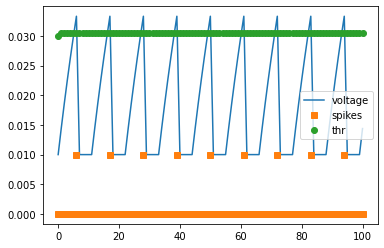

In [44]:
times = np.linspace(0, 100, 101)
ALIF_trial = ALIF_recurrent(n=10, type='input', n_ref=5, beta=1.8)
z_pres = 0.1*np.ones([len(times), ALIF_trial.n])
v_history = [ALIF_trial.v[0]]
z_history = [ALIF_trial.z[0]]
thr_history = [ALIF_trial.thr[0]]
for i in range(len(times)-1):
    ALIF_trial.dynamic(z_pres[i])
    v_history.append(ALIF_trial.v[0])
    z_history.append(ALIF_trial.z[0])
    thr_history.append(ALIF_trial.thr[0])

plt.plot(times, v_history, label='voltage')
plt.plot(times, 0.01*np.array(z_history), 's', label='spikes')
plt.plot(times, np.array(thr_history), 'o', label='thr')
#plt.xlim(0, 20)
plt.legend()
plt.show()

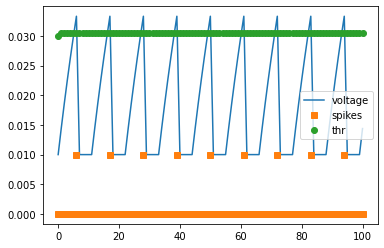

In [45]:
times = np.linspace(0, 100, 101)
ALIF_trial = ALIF_recurrent(n=10, type='hidden', n_in=5, n_ref=5, beta=1.8)
z_pres = 0.1*np.ones([len(times), ALIF_trial.n_in])
v_history = [ALIF_trial.v[0]]
z_history = [ALIF_trial.z[0]]
thr_history = [ALIF_trial.thr[0]]
for i in range(len(times)-1):
    ALIF_trial.dynamic(z_pres[i])
    v_history.append(ALIF_trial.v[0])
    z_history.append(ALIF_trial.z[0])
    thr_history.append(ALIF_trial.thr[0])

plt.plot(times, v_history, label='voltage')
plt.plot(times, 0.01*np.array(z_history), 's', label='spikes')
plt.plot(times, np.array(thr_history), 'o', label='thr')
#plt.xlim(0, 20)
plt.legend()
plt.show()

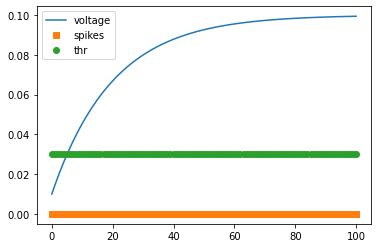

In [46]:
times = np.linspace(0, 100, 101)
ALIF_trial = ALIF_recurrent(n=10, type='output', n_in=5, n_ref=5, beta=1.8)
z_pres = 0.1*np.ones([len(times), ALIF_trial.n_in])
v_history = [ALIF_trial.v[0]]
z_history = [ALIF_trial.z[0]]
thr_history = [ALIF_trial.thr[0]]
for i in range(len(times)-1):
    ALIF_trial.dynamic(z_pres[i])
    v_history.append(ALIF_trial.v[0])
    z_history.append(ALIF_trial.z[0])
    thr_history.append(ALIF_trial.thr[0])


plt.plot(times, v_history, label='voltage')
plt.plot(times, 0.01*np.array(z_history), 's', label='spikes')
plt.plot(times, np.array(thr_history), 'o', label='thr')
#plt.xlim(0, 20)
plt.legend()
plt.show()

**Some utils functions**

In [47]:
# (DONE) - hardware-based modified-STDP
def Modified_STDP_weight_update(ratio, G_min, G_max, current_weight, 
                       alpha_p, alpha_m, beta_p, beta_m, potentiation = 1):
    '''
    Inputs:
        ratio: true_update_ratio/calculated_update_ratio by exponential funcion
        G_min: minimum conductance of a device
        G_max: maximum conductance of a device
        current_weight: current weight matrix
        alpha_p: alpha index for potentiation
        alpha_m: alpha index for depression 
        beta_p: beta index for potentiation
        beta_m: beta index for depression
        potentiation: = 1 for potentiation, = 0 for depression
    Return:
        updated_weights
    '''
    if potentiation == True: # for the case of potentiation
        delta_weight = alpha_p * np.exp(-beta_p*(current_weight-G_min)/(G_max-G_min))
        updated_weight = current_weight + delta_weight * ratio

    elif potentiation == False: # for the case of depression
        delta_weight = -alpha_m * np.exp(-beta_m*(G_max-current_weight)/(G_max-G_min))
        updated_weight = current_weight + delta_weight * ratio
    else:
        raise ValueError("Parameter potentiation must be 0 or 1!")

    return updated_weight

# calculate the change of weight/conductance with respect to z_pre and z_rec
def Modified_update_weight(w_in, z_pre, z_rec, G_min, G_max, alpha_p, alpha_m, beta_p, beta_m, ratios):
    '''For arbitrary spike trains - z_pre and z_rec, update the weight''' 
    assert (len(z_pre) == len(z_rec)), "two input spike trains should have the same length."
    w_in_history = []
    for i in range(len(z_pre)-1):
        if z_pre[i] != 0:
            if z_rec[i-1] != 0: #　depression
                w_in = Modified_STDP_weight_update(ratios[i], G_min, G_max, w_in, alpha_p, alpha_m, beta_p, beta_m, 0)
            elif z_rec[i+1] != 0: # potentiation
                w_in = Modified_STDP_weight_update(ratios[i], G_min, G_max, w_in, alpha_p, alpha_m, beta_p, beta_m, 1)
        w_in_history.append(w_in)
    return w_in_history

### **Main function**

In [48]:
# Step 1: define some constants

# Constants for the model
input_n = tf.constant(80)
input_exitatory_n = tf.constant(60)
input_inhibitary_n = tf.constant(20)
hidden_n = tf.constant(220)
hidden_LIF_n = tf.constant(120)
hidden_ALIF_n = hidden_n - hidden_LIF_n
output_n = tf.constant(10)
#print("Please specify the type of model (ALIF/LIF).")
#model = tf.string(str(input(" Model: ")))

# Constants for training and testing
#print("Please specify the constants for STDP weight update.")

#training_size = tf.constant(int(input(" Training size: ")))
#test_size = tf.constant(int(input(" Test size: ")))
training_size = 2000
test_size = 200
dampening_factor = 0.3 # dampening factor for pseudo gradient

# Constants for STDP
#print("Please specify the constants for STDP weight update.")

# potentiation
alpha_p = tf.constant(0.01, dtype=tf.double)
beta_p = tf.constant(3, dtype=tf.double)
#alpha_p = tf.constant(float(input(" alpha_p: ")))
#beta_p = tf.constant(float(input(" beta_p: ")))

# depression
alpha_m = tf.constant(0.005, dtype=tf.double)
beta_m = tf.constant(3, dtype=tf.double)
#alpha_m = tf.constant(float(input(" alpha_m: ")))
#beta_m = tf.constant(float(input(" beta_m: ")))

# device parameters
G_max = tf.constant(1.0, dtype=tf.double)
G_min = tf.constant(0.01, dtype=tf.double)
#G_max = tf.constant(float(input(" G_max: ")))
#G_min = tf.constant(float(input(" G_min: ")))

# time constants
t0 = 0 # initial time as 0
dt = 1 # timestep from  NIPS 2018

# ALIF/LIF neuron constants
tau_v = 20 # time constant for voltage changing from NIPS 2018
tau_a = 700 # time constant for adaptive threshold from NIPS 2018
thr = 0.1 # baseline threshold of ALIF neuron/threshold of LIF neuron
beta = 1.8 # Scaling constant of the adaptive threshold
n_delay = 10 # maximum synaptic delay
n_ref = 5 # number of refractory steps
v0 = 0.0 # membrane voltage at 0 timestep
dtype = tf.double # datatype of parameters inside neurons

# Homeostasis constants
target_activity = 10 # target activity per 40 time steps 
gamma = 5 # From Stephanie's paper
v_min = 0.005 # Ensure that threshold voltages can't get to 0
homeostasis_length = 40 # length to adjust the firing threshold 

In [49]:
# Step 2: read in the MNIST images and convert them to spike trains
def load_training_set(mnist_directory, training_size):
    """
    Load the MNIST digits for training. Shuffles them as well.

    Inputs: 
        mnist_directory - string: the directory to store MNIST dataset
        training_size - int : the size of training size
    Return:
        training_set - np.array: training_set of randomly selected images from MNIST with size of training_size
    """

    print("Loading MNIST for training (randomized)...")
    
    # Update global training_set variable
    # (training_set, training_labels), (testing_set, testing_labels) = tf.keras.datasets.mnist.load_data()
    f = gzip.open(mnist_directory, 'rb')
    
    # load sets using pickle
    # encoding necessary since pickle file was created in python 2.7
    train, valid, test = pickle.load(f,encoding='latin1')
    
    # split up into corresponding sets
    [training_set, training_labels] = train
    [validation_set, validation_labels] = valid
    [testing_set, testing_labels] = test
    
    # update training set
    training_set = np.concatenate((training_set, validation_set))
    training_labels = np.concatenate((training_labels, validation_labels))
    
    # close MNIST file
    f.close()

    #random_index = np.random.choice(training_set)
    random_index = np.random.choice(training_set.shape[0],training_size,replace=False)
    training_set = training_set[random_index] * 255

    training_labels = training_labels[random_index]

    #print(training_labels)

    #for i in range(5):
    #    plt.imshow(training_set[i].reshape(28,28))
    #    plt.show()

    return training_set, training_labels


# Reference repo: 
# https://github.com/intel-nrc-ecosystem/models/blob/master/nxsdk_modules_ncl/lsnn/tutorials/smnist_tutorial.ipynb
# Part: Encoding the images into spikes
# spike encoding example
def find_onset_offset(y, threshold):
    """
    Given the input signal y (one pixel in an image) with samples,
    find the indices where y increases and descreases through the value threshold.
    Return stacked binary arrays of shape y indicating onset and offset threshold crossings.
    y must be 1-D numpy arrays.
    """
    # Sanity check
    #assert (len(np.array(threshold)) == 1), "The length of threshold should be 1!"

    if threshold == 255:
        equal = y == threshold
        transition_touch = np.where(equal)[0]
        touch_spikes = np.zeros_like(y)
        touch_spikes[transition_touch] = 1
        return np.expand_dims(touch_spikes, axis=0)
    else:
        # Find where y crosses the threshold (increasing).
        lower = y < threshold # return boolen array
        higher = y >= threshold # return boolen array
        transition_onset = np.where(lower[:-1] & higher[1:])[0]
        transition_offset = np.where(higher[:-1] & lower[1:])[0]
        onset_spikes = np.zeros_like(y)
        offset_spikes = np.zeros_like(y)
        onset_spikes[transition_onset] = 1
        offset_spikes[transition_offset] = 1

    return np.stack((onset_spikes, offset_spikes))


# mnist image to input spikes
def img_to_spikes(input_px):
    """
    Converts MNIST images to spikes using a threshold crossing method.
    
    :param input_px: MNIST images data
    :return: spike data
    """
    numInput = 80

    # GENERATE THRESHOLD CROSSING SPIKES
    thrs = np.linspace(0, 255, numInput // 2)  # number of input neurons determins the resolution
    spike_stack = []
    for img in input_px:  # shape img = (784)
        Sspikes = None
        for thr in thrs:
            if Sspikes is not None:
                Sspikes = np.concatenate((Sspikes, find_onset_offset(img, thr)))
            else:
                Sspikes = find_onset_offset(img, thr)
        Sspikes = np.array(Sspikes)  # shape Sspikes = (31, 784)
        Sspikes = np.swapaxes(Sspikes, 0, 1)
        spike_stack.append(Sspikes)
    spike_stack = np.array(spike_stack)
    # add output cue neuron, and expand time for two image rows (2*28)
    out_cue_duration = 2*28
    spike_stack = np.lib.pad(spike_stack, ((0, 0), (0, out_cue_duration), (0, 1)), 'constant')
    # output cue neuron fires constantly for these additional recall steps
    spike_stack[:, -out_cue_duration:, -1] = 1

    return spike_stack

def image_process_pipeline(mnist_directory, training_size):
    training_set, training_labels = load_training_set(mnist_directory, training_size)
    #spike_trains_training_set = []
    spike_trains_training_set = img_to_spikes(training_set)

    print('Finish loading training data!')

    return np.array(spike_trains_training_set), training_set, training_labels

In [69]:
# will take a long time if full training set is loaded
spike_trains_training_set, training_set, training_labels = image_process_pipeline(\
    mnist_directory='D:\Chris\Chris projects\SNN_memtransistors\mnist.pkl.gz', \
    training_size=100)

Loading MNIST for training (randomized)...
Finish loading training data!


In [51]:
# spike train visualization for a single image
def visualize_spike_train(image_spike):
    #spike_trains_image = image_spike.reshape(80, 840)
    #print(len(spike_trains_image[90]))
    spike_trains_image = image_spike
    xs = np.linspace(1, len(image_spike), len(image_spike)) # 840 timesteps

    plt.figure()
    for i in range(len(xs)):
        # for each timestep
        h = 0
        for j in range(len(spike_trains_image[0])):
            # for each input neuron
            if spike_trains_image[i][j] != 0:
                plt.plot(xs[i], h+1, '.k')
            h += 1

    plt.ylim(0, 80)
    plt.xlabel('timestep')
    plt.ylabel('input neuron')
    plt.show()

In [52]:
#for i in range(5):
#    visualize_spike_train(spike_trains_training_set[i])
#    plt.imshow(training_set[i].reshape(28,28))
#    plt.show()

**3-layer SRNN model**

In [59]:
# object SRNN that strictly defined as a 3-layer model
class SRNN(tf.keras.Model):
    def __init__(self, input_layer, hidden_layer, output_layer):
        super().__init__()
        self.input_layer = input_layer
        self.hidden_layer = hidden_layer
        self.output_layer = output_layer
        #self.trainable_variables = [self.hidden_layer.w_in, self.hidden_layer.w_rec, \
        #                            self.output_layer.w_in]

    def __call__(self, image):
        '''
        Feed forward function for spike trains of a single image for sMNIST.
        Turn the model object into a callable project with one image without STDP update
        Can be used during prediction for calculating accuracy.

        inputs: spike trains of a single image for sMNIST
        '''
        z_input_pre = np.zeros(self.input_layer.n)
        z_hidden_pre = np.zeros(self.hidden_layer.n)
        z_input_hist = []
        z_hidden_hist = []

        for i in range(len(image)+2):
            # for each timestep
            try:
                pixel = image[i]
            except:
                pixel = np.zeros(len(image[0]))

            _, z_input = self.input_layer(pixel)
            z_input_hist.append(z_input)
            _, z_hidden = self.hidden_layer(z_input_pre)
            z_hidden_hist.append(z_hidden)
            self.output_layer(z_hidden_pre)

            z_input_pre = z_input
            z_hidden_pre = z_hidden

            return z_input_hist, z_hidden_hist

    def feed_forward(self, image, G_min, G_max, alpha_p, alpha_m, beta_p, beta_m, ratios = None, trainable = True,\
            target_activity = 40, gamma = 1e-5, adjust_every = 40):
        '''
        Feed forward function for spike trains of a single image for sMNIST with STDP.
        Turn train into False will make this function equivalent to __call__.

        inputs: spike trains of a single image for sMNIST
        '''
        # sanity checks
        if trainable == True and (ratios == None).all():
            raise ValueError("If trainable is True, ratio must not be None!")
        if len(image)!=len(ratios):
            raise ValueError("Number of input pixel of a single image should be equal to ratios!")

        z_input_hist = []
        z_hidden_hist = []

        # constant for adjusting threshold for homeostasis
        firing_rate = 0
        num_timestep = 0

        if trainable == False:
            z_input_hist, z_hidden_hist = self(image)

        elif trainable == True:

            z_input_pre = np.zeros(self.input_layer.n)
            z_hidden_pre = np.zeros(self.hidden_layer.n)

            for i in range(len(image)+2):
                # for each timestep
                try:
                    pixel = image[i]
                except:
                    pixel = np.zeros(len(image[0]))

                _, z_input = self.input_layer(pixel)
                z_input_hist.append(z_input)
                _, z_hidden = self.hidden_layer(z_input_pre)
                z_hidden_hist.append(z_hidden)

                firing_rate += np.sum(z_hidden) + np.sum(z_input)

                updated_weights = np.zeros([self.input_layer.n, self.hidden_layer.n])

                try:
                    ratio = tf.constant(ratios[i], dtype=tf.double)
                except:
                    ratio = 0 # no change in conductance at the 2 extra timesteps

                num_timestep += 1

                for j in range(len(z_input_pre)):
                    for k in range(len(z_hidden)):
                        if z_input_pre[j] != 0 and z_hidden[k] != 0:
                            if self.hidden_layer.w_in[j][k] <= G_max:
                                #print('potentiation')
                                updated_weights[j][k] = Modified_STDP_weight_update(ratio, G_min, G_max, \
                                    self.hidden_layer.w_in[j][k], alpha_p, alpha_m, beta_p, beta_m, potentiation=True)
                        elif z_input[j] != 0 and z_hidden_pre[k] !=0:
                            #print("depression1")
                            if self.hidden_layer.w_in[j][k] >= G_min:
                                updated_weights[j][k] = Modified_STDP_weight_update(ratio, G_min, G_max, \
                                    self.hidden_layer.w_in[j][k], alpha_p, alpha_m, beta_p, beta_m, potentiation=False)
                        elif z_input_pre[j] == 0 and z_hidden[k] !=0:
                            # depression 2 happens much more frequently than depression 1 - that's why it is slower
                            if self.hidden_layer.w_in[j][k] >= G_min:
                                #print("depression2")
                                updated_weights[j][k] = Modified_STDP_weight_update(ratio, G_min, G_max, \
                                    self.hidden_layer.w_in[j][k], alpha_p, alpha_m, beta_p, beta_m, potentiation=False)
                        else:
                            updated_weights[j][k] = self.hidden_layer.w_in[j][k]

                updated_weights = np.clip(updated_weights, G_min, G_max)
                self.hidden_layer.w_in = updated_weights

                self.output_layer(z_hidden_pre)

                z_input_pre = z_input
                z_hidden_pre = z_hidden

                # adjust threshold for homeostasis
                if num_timestep % adjust_every == 0:
                    self.hidden_layer.thr += gamma*(firing_rate - target_activity)
                    firing_rate = 0

        else:
            raise ValueError("Variable trainable must have a specified boolean value!")


        return self.output_layer.v, z_hidden_hist, z_input_hist

    # predict
    def predict(self, y_trues, MNIST_inputs):
        '''Prediction function of arbitrary number of images without STDP'''

        assert (len(y_trues)==len(MNIST_inputs)), \
            "The number of input images should be equivalent the number of true values."
        pred_lists = []
        acc = 0
        for inputs in MNIST_inputs:
            pred_list = []
            output = self.__call__(self, inputs)
            output_max = np.max(output.v)
            pred_list = []
            for v in output.v:
                if v == output_max:
                    pred_list.append(1)
                else:
                    pred_list.append(0)

            pred_lists.append(pred_list)
            if pred_list == y_trues:
                acc += 1

        return np.array(pred_lists), acc/len(y_trues)

    # save weights and states
    def save_model(self, dir, filename):
        save_file_full = dir+str(filename)
        print("Saving network and parameters in ", save_file_full,"...")

        # Saving data
        with open(save_file_full, 'wb') as f:
            # Save synapse states (weight, weight update)
            pickle.dump(self.hidden_layer.w_in, f)
            pickle.dump(self.hidden_layer.w_rec, f)
            pickle.dump(self.output_layer.w_in, f)

            # Save neuron states
            pickle.dump(self.input_layer.v, f)
            pickle.dump(self.input_layer.z, f)
            pickle.dump(self.hidden_layer.v, f)
            pickle.dump(self.hidden_layer.z, f)
            pickle.dump(self.output_layer.v, f)
        
        print("Saved!")

    # load weights to a certain pickle file
    def load_model(self, dir):
        '''
        must initialize first before loading weights
        '''

        # Load saved training parameters
        try:
            with open(dir, 'rb') as f:
                # load weight update values
                self.hidden_layer.w_in = pickle.load(f)
                self.hidden_layer.w_rec = pickle.load(f)
                self.output_layer.w_in = pickle.load(f)

                # load neuron states
                self.input_layer.v = pickle.load(f)
                self.input_layer.z = pickle.load(f)
                self.hidden_layer.v = pickle.load(f)
                self.hidden_layer.z = pickle.load(f)
                self.output_layer.v = pickle.load(f)  
 
        # If exception is thrown, print IO error statement
        except IOError as e:
            print("Error opening file: %s" % e.strerror)
            sys.exit()
      
    # fit - including feed-foward by STDP and BPTT
    def fit(self, ratios, G_min, G_max, alpha_p, alpha_m, beta_p, beta_m, inputs, y_trues, lr=0.01, \
                loss_func = tf.keras.losses.CategoricalCrossentropy(), opt = tf.keras.optimizers.Adam(learning_rate=0.1),\
                    verbose = True, print_every = 1, target_activity = 40, gamma = 1e-5, adjust_every = 40, \
                        save_every=10, dampening_factor=0.3):
        
        y_trues = tf.one_hot(y_trues, 10)
        self.loss_history = []
        assert(len(y_trues) == len(inputs)), "input digits should have the same length as labels!"

        # constant for adjusting threshold for homeostasis
        firing_rate = 0
        num_image = 0

        # feed-forward
        # hardware-based modified-STDP with various ratios to update w_1
        for i, input in enumerate(inputs):
            # feed-forward of a single-image
            with tf.GradientTape() as tape:
                tape.watch(tf.convert_to_tensor(self.output_layer.v))
                _, z_hidden_history, z_input_hisotry = self.feed_forward(ratios = ratios, image = input, G_min = G_min, G_max =  G_max, alpha_p = alpha_p, \
                alpha_m = alpha_m, beta_p = beta_p, beta_m = beta_m, trainable=True, target_activity=target_activity, \
                    gamma=gamma, adjust_every=adjust_every)
                # backprop through time (BPTT)
                # BPTT to update w_2 and w_1_rec
                # need psuedo gradient
                v_output = self.output_layer.v
                #print(v_output)
                y_pred = tf.nn.softmax(v_output)
                loss = loss_func(y_trues[i], y_pred)
                if i % print_every == 0 and verbose == True:
                    print('current loss: ' + str(loss.numpy()))
                    #print(self.hidden_layer.w_in[0])
                    #print(self.hidden_layer.w_rec[0])
                self.loss_history.append(loss.numpy())

            dL_dw2, dL_dv_output = tape.gradient(loss, [self.output_layer.w_in, v_output])
            #print(dL_dw2)

            dv_output_dz = (1-self.output_layer.alpha)*self.output_layer.w_in
            v_scaled = (self.hidden_layer.v - self.hidden_layer.thr)/self.hidden_layer.thr
            dz_dv_hidden = dampening_factor*tf.maximum(1 - tf.abs(v_scaled), 0) # from 2018 NIPS

            dv_hidden_dw_rec = 0
            z_hidden_history.reverse()
            
            for i, z in enumerate(z_hidden_history):
                dv_hidden_dw_rec += self.hidden_layer.alpha**i * (1 - self.hidden_layer.alpha) * z
            #print(dv_hidden_dw_rec.shape)
            #print(dz_dv_hidden.shape)
        
            dL_dw_rec = np.matmul(dv_output_dz, dL_dv_output) * dz_dv_hidden * dv_hidden_dw_rec
            print(dL_dw_rec)

            # update the value of w_2 and w_rec
            self.output_layer.w_in = tf.Variable((self.output_layer.w_in + lr*dL_dw2).numpy())
            self.hidden_layer.w_rec = tf.Variable((self.hidden_layer.w_rec + lr*dL_dw_rec).numpy())

            if i % save_every == 0:
                self.save_model(dir='D:/Chris/Chris projects/SNN_memtransistors/', filename='save_trail')

In [67]:
# initialize layers and models
# target_activity = 40, gamma = 1e-5, adjust_every = 40
# normal distribution of weight from 0 to 1
input_layer = LIF(n=80, type='input', n_ref=3)
hidden_layer = LIF_recurrent(n=220, type='hidden', n_in=80, n_ref=3)
hidden_layer.w_in = tf.Variable(np.clip(np.random.normal(loc=0.5, scale=0.1, size=(hidden_layer.n_in, hidden_layer.n)), G_min, G_max), trainable=True)
hidden_layer.w_rec = tf.Variable(np.clip(np.random.normal(loc=0.5, scale=0.1, size=hidden_layer.n), G_min, G_max), trainable=True) # initiate the recurrent weights
#print(hidden_layer.w_in[0])
#print(hidden_layer.w_rec[0])
output_layer = LIF(n=10, type='output', n_in=220, n_ref=3)
output_layer.w_in = tf.Variable(np.clip(np.random.normal(loc=0.5, scale=0.1, size=(output_layer.n_in, output_layer.n)), G_min, G_max), trainable=True)
#print(output_layer.w_in[0])

SRNN_trial = SRNN(input_layer=input_layer, hidden_layer=hidden_layer, output_layer=output_layer)
#print(SRNN_trial.hidden_layer.w_in)
ratios = np.ones(840)
SRNN_trial.fit(inputs = spike_trains_training_set, ratios = ratios, G_min = G_min, G_max = G_max, \
    alpha_p = alpha_p, alpha_m = alpha_m, beta_p = beta_p, beta_m = beta_m, y_trues = training_labels.tolist())
#print(SRNN_trial.hidden_layer.w_in)
SRNN_trial.save_model(dir='D:/Chris/Chris projects/SNN_memtransistors/', filename='save_trail')
#SRNN_2 = SRNN(input_layer=input_layer, hidden_layer=hidden_layer, output_layer=output_layer)
#SRNN_2.load_model(dir='D:/Chris/Chris projects/SNN_memtransistors/save_trail')
#print(SRNN_2.hidden_layer.w_in)

InvalidArgumentError: In[0] and In[1] has different ndims: [220] vs. [220,1] [Op:MatMul]

In [70]:
# initialize layers and models
# target_activity = 40, gamma = 1e-5, adjust_every = 40
# uniform distribution of weight from 0 to 1
input_layer = LIF(n=80, type='input', n_ref=3)
hidden_layer = LIF_recurrent(n=220, type='hidden', n_in=80, n_ref=3)
hidden_layer.w_in = tf.Variable((G_max - G_min)*np.random.rand(hidden_layer.n_in, hidden_layer.n) + G_min, trainable=True)
hidden_layer.w_rec = tf.Variable((G_max - G_min)*np.random.rand(hidden_layer.n), trainable=True) + G_min # initiate the recurrent weights
#print(hidden_layer.w_in[0])
#print(hidden_layer.w_rec[0])
output_layer = LIF(n=10, type='output', n_in=220, n_ref=3)
output_layer.w_in = tf.Variable((G_max - G_min)*np.random.rand(output_layer.n_in, output_layer.n) + G_min, trainable=True)
#print(output_layer.w_in[0])

SRNN_trial = SRNN(input_layer=input_layer, hidden_layer=hidden_layer, output_layer=output_layer)
#print(SRNN_trial.hidden_layer.w_in)
ratios = np.ones(840)
SRNN_trial.fit(inputs = spike_trains_training_set, ratios = ratios, G_min = G_min, G_max = G_max, \
    alpha_p = alpha_p, alpha_m = alpha_m, beta_p = beta_p, beta_m = beta_m, y_trues = training_labels.tolist())
#print(SRNN_trial.hidden_layer.w_in)
SRNN_trial.save_model(dir='D:/Chris/Chris projects/SNN_memtransistors/', filename='save_trail')
#SRNN_2 = SRNN(input_layer=input_layer, hidden_layer=hidden_layer, output_layer=output_layer)
#SRNN_2.load_model(dir='D:/Chris/Chris projects/SNN_memtransistors/save_trail')
#print(SRNN_2.hidden_layer.w_in)

current loss: 2.4037163257598877
current loss: 2.2597262859344482
current loss: 2.2784292697906494
current loss: 2.278557777404785
current loss: 2.2966115474700928
current loss: 2.329524517059326
current loss: 2.304450750350952
current loss: 2.334468364715576
current loss: 2.3041036128997803
current loss: 2.2911953926086426
current loss: 2.298689603805542
current loss: 2.2986998558044434
current loss: 2.300212860107422
current loss: 2.32383131980896
current loss: 2.298480749130249
current loss: 2.299471616744995
current loss: 2.2963099479675293
current loss: 2.2969229221343994
current loss: 2.3025851249694824
current loss: 2.30257248878479
current loss: 2.3026020526885986
current loss: 2.3025853633880615
current loss: 2.3025882244110107
current loss: 2.302586078643799
current loss: 2.3025736808776855
current loss: 2.302588939666748
current loss: 2.302556037902832
current loss: 2.3026087284088135
current loss: 2.3025853633880615
current loss: 2.3025853633880615
current loss: 2.302583694

In [56]:
SRNN_trial.loss_history

ListWrapper([2.300302028656006, 2.3016715049743652, 2.3040435314178467, 2.3025827407836914, 2.302586793899536, 2.3025848865509033, 2.3025832176208496, 2.3025851249694824, 2.3025853633880615, 2.302582263946533])

In [93]:
# initialize layers and models
# # target_activity = 40, gamma = 1e-5, adjust_every = 40
input_layer = LIF(n=80, type='input', n_ref=3, thr = 1.0)
hidden_layer = LIF_recurrent(n=220, type='hidden', n_in=80, n_ref=3, thr = 1.0)
hidden_layer.w_in = tf.Variable(0.04*np.random.rand(hidden_layer.n_in, hidden_layer.n), trainable=True)
#print(hidden_layer.w_in)
output_layer = LIF(n=10, type='output', n_in=220, n_ref=3, thr = 0.1)
output_layer.w_in = tf.Variable(0.04*np.random.rand(output_layer.n_in, output_layer.n), trainable=True)

SRNN_trial = SRNN(input_layer=input_layer, hidden_layer=hidden_layer, output_layer=output_layer)
#print(SRNN_trial.hidden_layer.w_in)
ratios = np.ones(840)
SRNN_trial.fit(inputs = spike_trains_training_set, ratios = ratios, G_min = G_min, G_max = G_max, \
    alpha_p = alpha_p, alpha_m = alpha_m, beta_p = beta_p, beta_m = beta_m, y_trues = training_labels.tolist())
#print(SRNN_trial.hidden_layer.w_in)
SRNN_trial.save_model(dir='D:/Chris/Chris projects/SNN_memtransistors/', filename='save_trail')
#SRNN_2 = SRNN(input_layer=input_layer, hidden_layer=hidden_layer, output_layer=output_layer)
#SRNN_2.load_model(dir='D:/Chris/Chris projects/SNN_memtransistors/save_trail')
#print(SRNN_2.hidden_layer.w_in)

current loss: 2.3025851249694824
[[0.03562728 0.01859558 0.01791236 ... 0.01       0.03412506 0.01920831]
 [0.01       0.01987237 0.01       ... 0.03927392 0.01       0.03902339]
 [0.02344571 0.01681027 0.01944328 ... 0.01       0.01       0.01790664]
 ...
 [0.03817927 0.02896484 0.0234918  ... 0.01674697 0.01227415 0.01      ]
 [0.01       0.01       0.03877176 ... 0.01       0.01       0.02712389]
 [0.03517979 0.02742864 0.01686703 ... 0.01770553 0.01       0.01247002]]
current loss: 2.3025851249694824
[[0.03562728 0.01859558 0.01791236 ... 0.01       0.03412506 0.01920831]
 [0.01       0.01987237 0.01       ... 0.03927392 0.01       0.03902339]
 [0.02344571 0.01681027 0.01944328 ... 0.01       0.01       0.01790664]
 ...
 [0.03817927 0.02896484 0.0234918  ... 0.01674697 0.01227415 0.01      ]
 [0.01       0.01       0.03877176 ... 0.01       0.01       0.02712389]
 [0.03517979 0.02742864 0.01686703 ... 0.01770553 0.01       0.01247002]]
current loss: 2.3025851249694824
[[0.03562728 

In [89]:
# initialize layers and models
# # target_activity = 40, gamma = 1e-5, adjust_every = 40
input_layer = LIF(n=80, type='input', n_ref=3)
hidden_layer = LIF_recurrent(n=220, type='hidden', n_in=80, n_ref=3)
output_layer = LIF(n=10, type='output', n_in=220, n_ref=3)

SRNN_trial = SRNN(input_layer=input_layer, hidden_layer=hidden_layer, output_layer=output_layer)
#print(SRNN_trial.hidden_layer.w_in)
ratios = np.ones(840)
SRNN_trial.fit(inputs = spike_trains_training_set, ratios = ratios, G_min = G_min, G_max = G_max, \
    alpha_p = alpha_p, alpha_m = alpha_m, beta_p = beta_p, beta_m = beta_m, y_trues = training_labels.tolist())
#print(SRNN_trial.hidden_layer.w_in)
SRNN_trial.save_model(dir='D:/Chris/Chris projects/SNN_memtransistors/', filename='save_trail')
#SRNN_2 = SRNN(input_layer=input_layer, hidden_layer=hidden_layer, output_layer=output_layer)
#SRNN_2.load_model(dir='D:/Chris/Chris projects/SNN_memtransistors/save_trail')
#print(SRNN_2.hidden_layer.w_in)

current loss: 2.3025851249694824
[[0.19125648 0.18996472 0.19955727 ... 0.2        0.2        0.2       ]
 [0.19125648 0.18996472 0.19955727 ... 0.2        0.2        0.2       ]
 [0.29272181 0.18996472 0.19955727 ... 0.2        0.2        0.2       ]
 ...
 [0.19125648 0.27236804 0.19911514 ... 0.2        0.2        0.2       ]
 [0.19125648 0.18996472 0.19955727 ... 0.2        0.2        0.2       ]
 [0.19125648 0.18996472 0.19955727 ... 0.2        0.2        0.2       ]]
current loss: 2.302583932876587
[[0.18064331 0.18273879 0.19823265 ... 0.2        0.2        0.2       ]
 [0.18064331 0.18273879 0.19823265 ... 0.2        0.2        0.2       ]
 [0.36152127 0.18273879 0.19823265 ... 0.2        0.2        0.2       ]
 ...
 [0.18064331 0.3064543  0.19735252 ... 0.2        0.2        0.2       ]
 [0.18064331 0.18273879 0.19823265 ... 0.2        0.2        0.2       ]
 [0.18064331 0.18273879 0.19823265 ... 0.2        0.2        0.2       ]]
current loss: 2.3025851249694824
[[0.17157814 0

In [94]:
SRNN_trial.hidden_layer.w_in[0]

array([0.03562728, 0.01859558, 0.01791236, 0.02000348, 0.01796277,
       0.01      , 0.03855658, 0.01097983, 0.01      , 0.01769372,
       0.026481  , 0.01      , 0.01570464, 0.01      , 0.01      ,
       0.03931967, 0.01      , 0.01      , 0.01203948, 0.01555656,
       0.01627282, 0.01151888, 0.02817631, 0.01      , 0.03583794,
       0.01564804, 0.01      , 0.03818625, 0.01478121, 0.01      ,
       0.02545665, 0.02754628, 0.02433511, 0.0214278 , 0.01929693,
       0.02570937, 0.01690275, 0.01      , 0.01      , 0.02183566,
       0.03193634, 0.01941477, 0.02507925, 0.01      , 0.02127224,
       0.01      , 0.01      , 0.02085914, 0.01      , 0.01710489,
       0.0295741 , 0.01      , 0.02012521, 0.02813472, 0.01      ,
       0.02880504, 0.02908899, 0.0191902 , 0.03710095, 0.01      ,
       0.0261725 , 0.0148526 , 0.01569879, 0.01942419, 0.01828456,
       0.01468172, 0.02712515, 0.03410855, 0.01070149, 0.01      ,
       0.01      , 0.02361023, 0.03335236, 0.01      , 0.02320

In [95]:
SRNN_trial.hidden_layer.w_rec

<tf.Variable 'Variable:0' shape=(220,) dtype=float64, numpy=
array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
   

In [96]:
SRNN_trial.output_layer.w_in

<tf.Variable 'Variable:0' shape=(220, 10) dtype=float64, numpy=
array([[0.00548411, 0.02862449, 0.01560684, ..., 0.0086141 , 0.01450116,
        0.01890208],
       [0.02901912, 0.0127789 , 0.00561835, ..., 0.00888832, 0.03026416,
        0.02505569],
       [0.01226995, 0.02712066, 0.01795882, ..., 0.02599381, 0.00853065,
        0.01942311],
       ...,
       [0.00345091, 0.00014804, 0.02135237, ..., 0.01580905, 0.02456378,
        0.03006767],
       [0.03271933, 0.01857662, 0.02204364, ..., 0.02025538, 0.0123568 ,
        0.03296093],
       [0.01752869, 0.03099648, 0.00725172, ..., 0.03976102, 0.01438738,
        0.03287128]])>

In [42]:
# initialize layers and models - gamma = 1e-5
input_layer = LIF(n=80, type='input', n_ref=3)
hidden_layer = LIF_recurrent(n=220, type='hidden', n_in=80, n_ref=3)
output_layer = LIF(n=10, type='output', n_in=220, n_ref=3)

SRNN_trial = SRNN(input_layer=input_layer, hidden_layer=hidden_layer, output_layer=output_layer)
#print(type(SRNN_trial.output_layer.v))
ratios = np.ones(840)
SRNN_trial.fit(inputs = spike_trains_training_set, ratios = ratios, G_min = G_min, G_max = G_max, \
    alpha_p = alpha_p, alpha_m = alpha_m, beta_p = beta_p, beta_m = beta_m, y_trues = training_labels.tolist())

current loss: 2.3025851249694824
current loss: 2.302577495574951
current loss: 2.3027729988098145
current loss: 2.302551746368408
current loss: 2.30253267288208
current loss: 2.3026130199432373
current loss: 2.302586317062378
current loss: 2.3025600910186768
current loss: 2.3025481700897217
current loss: 2.302530288696289
current loss: 2.3025126457214355
current loss: 2.3025052547454834
current loss: 2.302544593811035
current loss: 2.3027455806732178
current loss: 2.302719831466675
current loss: 2.3022396564483643
current loss: 2.302250385284424
current loss: 2.3028056621551514
current loss: 2.303292751312256
current loss: 2.3031342029571533


In [39]:
# initialize layers and models - gamma = 1e-5
input_layer = LIF(n=80, type='input', n_ref=3)
hidden_layer = LIF_recurrent(n=220, type='hidden', n_in=80, n_ref=3)
output_layer = LIF(n=10, type='output', n_in=220, n_ref=3)

SRNN_trial = SRNN(input_layer=input_layer, hidden_layer=hidden_layer, output_layer=output_layer)
#print(type(SRNN_trial.output_layer.v))
ratios = np.ones(840)
SRNN_trial.fit(inputs = spike_trains_training_set, ratios = ratios, G_min = G_min, G_max = G_max, \
    alpha_p = alpha_p, alpha_m = alpha_m, beta_p = beta_p, beta_m = beta_m, y_trues = training_labels.tolist())

current loss: 2.3025851249694824
current loss: 2.3025684356689453
current loss: 2.311573028564453
current loss: 2.3005852699279785
current loss: 2.2995858192443848
current loss: 2.298750877380371
current loss: 2.31765079498291
current loss: 2.296595573425293
current loss: 2.3056280612945557
current loss: 2.304628849029541
current loss: 2.2935872077941895
current loss: 2.292573928833008
current loss: 2.3015685081481934
current loss: 2.3105709552764893
current loss: 2.2995712757110596
current loss: 2.2987985610961914
current loss: 2.297607183456421
current loss: 2.3066017627716064
current loss: 2.3156144618988037
current loss: 2.3146941661834717


In [40]:
SRNN_trial.hidden_layer.w_in

array([[0.        , 0.13108601, 0.19955727, ..., 0.2       , 0.2       ,
        0.2       ],
       [0.        , 0.13108601, 0.19955727, ..., 0.2       , 0.2       ,
        0.2       ],
       [0.        , 0.13108601, 0.19955727, ..., 0.2       , 0.2       ,
        0.2       ],
       ...,
       [0.        , 0.13108601, 0.19955727, ..., 0.2       , 0.2       ,
        0.2       ],
       [0.        , 0.13108601, 0.19955727, ..., 0.2       , 0.2       ,
        0.2       ],
       [0.        , 0.19236502, 0.19955727, ..., 0.2       , 0.2       ,
        0.2       ]])

In [38]:
# initialize layers and models - gamma - 1e-6
input_layer = LIF(n=80, type='input', n_ref=3)
hidden_layer = LIF_recurrent(n=220, type='hidden', n_in=80, n_ref=3)
output_layer = LIF(n=10, type='output', n_in=220, n_ref=3)

SRNN_trial = SRNN(input_layer=input_layer, hidden_layer=hidden_layer, output_layer=output_layer)
#print(type(SRNN_trial.output_layer.v))
ratios = np.linspace(1.0, 0.5, 840)
SRNN_trial.fit(inputs = spike_trains_training_set, ratios = ratios, G_min = G_min, G_max = G_max, \
    alpha_p = alpha_p, alpha_m = alpha_m, beta_p = beta_p, beta_m = beta_m, y_trues = training_labels.tolist())


current loss: 2.3025851249694824
current loss: 2.3025763034820557
current loss: 2.302556276321411
current loss: 2.302640199661255
current loss: 2.3025436401367188
current loss: 2.302492380142212
current loss: 2.302459239959717
current loss: 2.3024420738220215
current loss: 2.3026576042175293
current loss: 2.30245041847229
current loss: 2.302321434020996
current loss: 2.3028628826141357
current loss: 2.3025963306427
current loss: 2.3019521236419678
current loss: 2.302401304244995
current loss: 2.3024284839630127
current loss: 2.3017380237579346
current loss: 2.3030121326446533
current loss: 2.30202054977417
current loss: 2.3021068572998047
current loss: 2.3023016452789307
current loss: 2.301900863647461
current loss: 2.303224802017212
current loss: 2.3027238845825195
current loss: 2.3032476902008057
current loss: 2.302393913269043
current loss: 2.3026320934295654
current loss: 2.3035261631011963
current loss: 2.301705837249756
current loss: 2.301393747329712
current loss: 2.302013158798

In [39]:
# initialize layers and models
input_layer = LIF(n=80, type='input', n_ref=3)
hidden_layer = LIF_recurrent(n=220, type='hidden', n_in=80, n_ref=3)
output_layer = LIF(n=10, type='output', n_in=220, n_ref=3)

SRNN_trial = SRNN(input_layer=input_layer, hidden_layer=hidden_layer, output_layer=output_layer)
#print(type(SRNN_trial.output_layer.v))
ratios = np.ones(840)
SRNN_trial.fit(inputs = spike_trains_training_set, ratios = ratios, G_min = G_min, G_max = G_max, \
    alpha_p = alpha_p, alpha_m = alpha_m, beta_p = beta_p, beta_m = beta_m, y_trues = training_labels.tolist())

current loss: 2.3025851249694824
current loss: 2.302572250366211
current loss: 2.302546262741089
current loss: 2.3026790618896484
current loss: 2.302492380142212
current loss: 2.302480459213257
current loss: 2.302447557449341
current loss: 2.3023934364318848
current loss: 2.3027920722961426
current loss: 2.302785634994507
current loss: 2.3020987510681152
current loss: 2.3031139373779297
current loss: 2.3022921085357666
current loss: 2.301896333694458
current loss: 2.3027021884918213
current loss: 2.3025355339050293
current loss: 2.3016555309295654
current loss: 2.302969455718994
current loss: 2.3018436431884766
current loss: 2.302324056625366
current loss: 2.3016648292541504
current loss: 2.3020272254943848
current loss: 2.3031694889068604
current loss: 2.302924394607544
current loss: 2.303532361984253
current loss: 2.303009271621704
current loss: 2.301910638809204
current loss: 2.3035082817077637
current loss: 2.30157208442688
current loss: 2.302031993865967
current loss: 2.3018217086

In [65]:
hidden_layer = LIF_recurrent(n=10, type='hidden', n_in=10, n_ref=3)
hidden_layer.thr

array([0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03])

In [41]:
SRNN_trial.hidden_layer.w_rec

<tf.Variable 'Variable:0' shape=(220,) dtype=float64, numpy=
array([0.2       , 0.2       , 0.2       , 0.2       , 0.19999843,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
 

In [ ]:
# initialize layers and models
input_layer = LIF(n=80, type='input', n_ref=3)
hidden_layer = LIF_recurrent(n=220, type='hidden', n_in=80, n_ref=3)
output_layer = LIF(n=10, type='output', n_in=220, n_ref=3)

SRNN_trial = SRNN(input_layer=input_layer, hidden_layer=hidden_layer, output_layer=output_layer)
#print(type(SRNN_trial.output_layer.v))
ratios = np.ones(840)
SRNN_trial.fit(inputs = spike_trains_training_set, ratios = ratios, G_min = G_min, G_max = G_max, \
    alpha_p = alpha_p, alpha_m = alpha_m, beta_p = beta_p, beta_m = beta_m, y_trues = training_labels.tolist())

array([[0.2       , 0.2       , 0.2       , ..., 0.2       , 0.2       ,
        0.2       ],
       [0.2       , 0.2       , 0.2       , ..., 0.2       , 0.2       ,
        0.2       ],
       [0.50313232, 0.50313232, 0.50313232, ..., 0.50313232, 0.50313232,
        0.50313232],
       ...,
       [0.34400892, 0.34400892, 0.34400892, ..., 0.34400892, 0.34400892,
        0.34400892],
       [0.2       , 0.2       , 0.2       , ..., 0.2       , 0.2       ,
        0.2       ],
       [0.25236284, 0.25236284, 0.25236284, ..., 0.25236284, 0.25236284,
        0.25236284]])

In [39]:
# initialize layers and models
input_layer = LIF(n=80, type='input', n_ref=3)
hidden_layer = LIF_recurrent(n=220, type='hidden', n_in=80, n_ref=3)
output_layer = LIF(n=10, type='output', n_in=220, n_ref=3)

SRNN_trial = SRNN(input_layer=input_layer, hidden_layer=hidden_layer, output_layer=output_layer)
#print(type(SRNN_trial.output_layer.v))
ratios = np.linspace(1.0, 0.5, 840)
SRNN_trial.fit(inputs = spike_trains_training_set, ratios = ratios, G_min = G_min, G_max = G_max, \
    alpha_p = alpha_p, alpha_m = alpha_m, beta_p = beta_p, beta_m = beta_m, y_trues = training_labels.tolist())

current loss: 2.3025851249694824
current loss: 2.3010172843933105
current loss: 2.2994487285614014
current loss: 2.3136229515075684
current loss: 2.2974185943603516
current loss: 2.309483766555786
current loss: 2.325300931930542
current loss: 2.2921676635742188
current loss: 2.303601026535034
current loss: 2.3153703212738037
current loss: 2.2903008460998535
current loss: 2.286376476287842
current loss: 2.284771203994751
current loss: 2.2988967895507812
current loss: 2.297593355178833
current loss: 2.295861005783081
current loss: 2.2783284187316895
current loss: 2.316572666168213
current loss: 2.291273832321167
current loss: 2.289618730545044
current loss: 2.304445743560791
current loss: 2.322669744491577
current loss: 2.332280158996582
current loss: 2.3002004623413086
current loss: 2.348950147628784
current loss: 2.352639675140381
current loss: 2.29575252532959
current loss: 2.310882806777954
current loss: 2.3250925540924072
current loss: 2.3073225021362305
current loss: 2.369414806365

### Junk codes

In [ ]:
#　Adaptive leaky integrate-and-fire neuron layer (recurrent)
class ALIF_recurrent(LIF_recurrent):
    def __init__(self, n, type, n_in = None, thr = 0.03, dt = 1.0, n_ref=0, tau_v = 20, tau_a = 700, w0_in = 0.2,
               w0_rec = 0.1, n_delay = 1, injected_noise_current=0., v0 = 0.01, beta=1.8):
        super(ALIF_recurrent, self).__init__(n = n, type = type, n_in = n_in, thr = thr, dt = dt, n_ref = n_ref, tau_v = tau_v,
                                 n_delay = n_delay, w0_in = w0_in,
                                 w0_rec = w0_rec, injected_noise_current = injected_noise_current, v0 = v0)
        self.beta = beta
        self.tau_a = tau_a
        self.rou = np.exp(-self.dt/self.tau_a)
        self.thr_init = thr
        
        
    def dynamic(self, z_pre):
        '''
        Function that generate the next spike and voltage tensor.
        Param 
            z_pre: spike train from previous layer of neuron/inputs 
        Return
            self.v: voltages of next time step
            self.z: spikes of next time step
            self.thr_list: thresholds of next time step
        '''
        # define the current 
        if type(z_pre) != tf.Tensor: 
            z_pre = tf.convert_to_tensor(z_pre)

        if self.type == 'hidden' or self.type == 'output':
            if z_pre.shape != (self.n_in, 1): 
                z_pre = tf.reshape(z_pre, shape = (self.n_in, 1))
        else:
            if z_pre.shape != (self.n, 1): 
                z_pre = tf.reshape(z_pre, shape = (self.n, ))

        #print(tf.reshape(tf.Variable(self.z), shape=(10, 1)))
        
        if self.type == 'hidden' or self.type == 'output':
            current = tf.linalg.matmul(tf.transpose(self.w_in), z_pre) + \
                tf.reshape(self.w_rec, shape=(self.n, 1)).numpy() * tf.reshape(tf.Variable(self.z), shape=(self.n, 1)).numpy()
        else:
            current = z_pre + self.z

        # add random noise to current
        if self.injected_noise_current > 0:
            if self.type == 'input':
                current = current + tf.random.normal(shape=self.n, stddev=self.injected_noise_current)
            elif self.type == 'hidden' or self.type == 'output':
                current = current + tf.random.normal(shape=(self.n_in, self.n), stddev=self.injected_noise_current)

        current = tf.reshape(current, shape=(self.n, ))
        
            
        # update the voltage, threshold and spike of this layer
        if self.type == 'input':
            for i in range(len(self.v)): # for a certain neuron in this layer
                # judge whether to update the voltage or not
                if self.ref_tag[i]==1 and self.ref_time[i] < self.n_ref: # if it's in refractory period and ref_time < n_ref
                    self.ref_time[i] += 1
                    self.v[i] = self.v0
                elif self.ref_tag[i]==1 and self.ref_time[i] == self.n_ref:
                    self.ref_tag[i] = 0
                    self.ref_time[i] = 0
                    self.v[i] = self.v0
                else:
                    self.v[i] = self.alpha * self.v[i] + (1-self.alpha)*current[i]

                # judge if emit spike or not
                if self.v[i] > self.thr[i]:
                    self.z[i] = 1 # emit spike 
                    self.ref_time[i] += 1 # add timer to count the reference time
                    self.ref_tag[i] = 1

                else:
                    self.z[i] = 0

            # update threshold
            self.thr = self.thr_init + self.beta*(self.rou*self.thr+(1-self.rou)*self.z)*self.v0

        # for hidden layer
        elif self.type == 'hidden':

            voltage = self.v0
            index = 0

            for i in range(len(self.v)): # for a certain neuron in this layer
                # judge whether to update the voltage or not
                if self.spike == False:
                    if self.ref_tag[i]==1 and self.ref_time[i] < self.n_ref: # if it's in refractory period and ref_time < n_ref
                        self.ref_time[i] += 1
                        self.v[i] = self.v0
                    elif self.ref_tag[i]==1 and self.ref_time[i] == self.n_ref:
                        self.ref_tag[i] = 0
                        self.ref_time[i] = 0
                        self.v[i] = self.v0
                    else:
                        self.v[i] = self.alpha * self.v[i] + (1-self.alpha)*current[i]

                # judge if emit spike or not
                if self.v[i] > self.thr[i]:
                    if self.spike == False:
                        self.z[i] = 1 # emit spike 
                        self.ref_time[i] += 1 # add timer to count the reference time
                        voltage = self.v[i]
                        index = i
                        self.ref_tag[i] = 1
                        self.spike = True
                        #print('emit spike on '+str(index)+'th neuron with voltage of '+str(voltage)+'!')
                    elif self.spike == True:
                        self.z[i] = 0 # emit spike 
                        self.ref_time[i] += 1 # add timer to count the reference time
                        self.ref_tag[i] = 1

                else:
                    self.z[i] = 0
            
            # reassign the value considereing the lateral inhibition
            if self.spike == True:
                spike_list = np.zeros(self.n)
                spike_list[index] = 1
                voltage_list = self.v0 * np.ones(self.n)
                voltage_list[index] = voltage
                self.v = voltage_list
                self.z = spike_list
                self.spike = False

            # update threshold
            self.thr = self.thr_init + self.beta*(self.rou*self.thr+(1-self.rou)*self.z)*self.v0
      
        else:
            self.v = self.alpha * self.v + (1-self.alpha)*current

        return self.v, self.z, self.thr


    def __call__(self, z_pre):
        '''
        Turn the object into a callable project with emitted spikes
        '''
        v, z, _ = self.dynamic(z_pre)
        return v, z

In [ ]:
#　leaky integrate-and-fire neuron layer (recurrent)
class LIF_recurrent(IF_recurrent):
    def __init__(self, n, type, n_in = None, thr = 0.03, dt = 1.0, n_ref=0, tau_v = 20, w0_in = 0.2, 
                w0_rec = 0.2, n_delay = 1, injected_noise_current=0., v0 = 0.01):
        super(LIF_recurrent, self).__init__(n = n, type = type, n_in = n_in, thr = thr, dt = dt, n_ref = n_ref, 
                                 n_delay = n_delay, w0_in = w0_in,
                                 w0_rec = w0_rec, injected_noise_current = injected_noise_current, v0 = v0)
        self.tau_v = tau_v
        self.alpha = np.exp(-self.dt/self.tau_v)
        
    def dynamic(self, z_pre):
        '''
        Function that generate the next spike and voltage tensor.
        Param 
            z_pre: spike train from previous layer of neuron/inputs 
        Return
            self.v: voltages of next time step
            self.z: spikes of next time step
        '''
        # define the current 
        if type(z_pre) != tf.Tensor: 
            z_pre = tf.convert_to_tensor(z_pre)

        if self.type == 'hidden' or self.type == 'output':
            if z_pre.shape != (self.n_in, 1): 
                z_pre = tf.reshape(z_pre, shape = (self.n_in, 1))
        else:
            if z_pre.shape != (self.n, 1): 
                z_pre = tf.reshape(z_pre, shape = (self.n, ))
        
        if self.type == 'hidden' or self.type == 'output':
            current = tf.linalg.matmul(tf.transpose(self.w_in), z_pre) + \
                tf.reshape(self.w_rec, shape=(self.n, 1)).numpy() * tf.reshape(tf.Variable(self.z), shape=(self.n, 1)).numpy()
        else:
            current = z_pre + self.z


        # add random noise to current
        if self.injected_noise_current > 0:
            if self.type == 'input':
                current = current + tf.random.normal(shape=self.n, stddev=self.injected_noise_current)
            elif self.type == 'hidden' or self.type == 'output':
                current = current + tf.random.normal(shape=(self.n_in, self.n), stddev=self.injected_noise_current)
        

        current = tf.reshape(current, shape=(self.n, ))
        
            
        # update the voltage and spike of this layer
        # for input layer
        if self.type == 'input':
            for i in range(len(self.v)): # for a certain neuron in this layer
                # judge whether to update the voltage or not
                if self.ref_tag[i]==1 and self.ref_time[i] < self.n_ref: # if it's in refractory period and ref_time < n_ref
                    self.ref_time[i] += 1
                    self.v[i] = self.v0
                elif self.ref_tag[i]==1 and self.ref_time[i] == self.n_ref:
                    self.ref_tag[i] = 0
                    self.ref_time[i] = 0
                    self.v[i] = self.v0
                else:
                    self.v[i] = self.alpha*self.v[i] + (1-self.alpha)*current[i]

                # judge if emit spike or not
                if self.v[i] > self.thr[i]:
                    self.z[i] = 1 # emit spike 
                    self.ref_time[i] += 1 # add timer to count the reference time
                    self.ref_tag[i] = 1

                else:
                    self.z[i] = 0
        
        # for hidden layer
        elif self.type == 'hidden':

            voltage = self.v0
            index = 0

            for i in range(len(self.v)): # for a certain neuron in this layer
                # judge whether to update the voltage or not
                if self.spike == False:
                    if self.ref_tag[i]==1 and self.ref_time[i] < self.n_ref: # if it's in refractory period and ref_time < n_ref
                        self.ref_time[i] += 1
                        self.v[i] = self.v0
                    elif self.ref_tag[i]==1 and self.ref_time[i] == self.n_ref:
                        self.ref_tag[i] = 0
                        self.ref_time[i] = 0
                        self.v[i] = self.v0
                    else:
                        self.v[i] = self.alpha * self.v[i] + (1-self.alpha)*current[i]

                # judge if emit spike or not
                if self.v[i] > self.thr[i]:
                    if self.spike == False:
                        self.z[i] = 1 # emit spike 
                        self.ref_time[i] += 1 # add timer to count the reference time
                        voltage = self.v[i]
                        index = i
                        self.ref_tag[i] = 1
                        self.spike = True
                    #print('emit spike on '+str(index)+'th neuron with voltage of '+str(voltage)+'!')
                    elif self.spike == True:
                        self.z[i] = 0 # emit spike 
                        self.ref_time[i] += 1 # add timer to count the reference time
                        self.ref_tag[i] = 1

                else:
                    self.z[i] = 0

            # reassign the value considereing the lateral inhibition
            if self.spike == True:
                spike_list = np.zeros(self.n)
                spike_list[index] = 1
                voltage_list = self.v0 * np.ones(self.n)
                voltage_list[index] = voltage
                self.v = voltage_list
                self.z = spike_list
                self.spike = False


        # for output layer
        else:
            self.v = self.alpha * self.v + (1-self.alpha)*current

        return self.v, self.z

In [ ]:
Cell_reccurent = tf.keras.layers.AbstractRNNCell

# integrate-and-fire neuron layer (recurrent)
class IF_recurrent(Cell_reccurent):
    def __init__(self, n, type, n_in = None, thr = 0.03, dt = 1.0, n_ref = 2,
        n_delay = 1, injected_noise_current=0., v0 = 0.01, w0_in = 0.1, w0_rec = 0.1):
        '''
        Initialize the integrate-and-fire (IF) neuron layer object.
        Parameters:
            n: number of neuron in this layer
            type: input/hidden/output
            n_in: number of neuron in the previous layer
            thr: threshold voltage of IF neuron
            dt: timestep for voltage update in ms
            n_ref: number of refractory timestep
            n_delay: number of delay timestep
            dampening_factor: dampening_factor used in pseud-gradient during BPTT
            injected_noise_current: noise current from hardware/variance of hardware
            v0: value of initial membrane voltage
            w0: value of initial weight
        '''
        self.n = n 
        self.thr = thr*np.ones([self.n])
        self.dt = dt
        self.n_ref = n_ref
        self.n_delay = n_delay
        self.injected_noise_current = injected_noise_current # can be used to simulate the device noise/variation
        assert (v0 < thr), "Static voltage should be smaller the threshold!"
        self.type = type
        self.v0 = v0
        self.v = self.v0 * np.ones(self.n) # self.v - an array of # self.n that contain the membrane voltage of this layer
        self.z = np.zeros(self.n) # self.z - an array of # self.n that contain possible spikes of this layer
        self.ref_time = np.zeros(self.n)
        self.ref_tag = np.zeros(self.n) # defualt is not in refractory state
        self.w_rec = tf.Variable(w0_rec*np.ones(self.n), trainable=True) # initiate the recurrent weights

        if self.type == 'input':
            pass
        elif self.type == 'hidden':
            if n_in != None:
                assert(n_in >= 0), "For hidden layer, the number of input neuron should be larger than 0!"
                self.n_in = n_in
                self.w_in = tf.Variable(w0_in*np.ones([self.n_in, self.n]), trainable=True)
                self.spike = False # to record if a neuron is fired in a certain timestep or not for lateral inhibition
            else:
                raise ValueError("Hidden layer should have specific neuron from previous layer!")
        elif self.type == 'output':
            if n_in != None:
                assert(n_in >= 0), "For output layer, the number of input neuron should be larger than 0!"
                self.n_in = n_in
                self.w_in = tf.Variable(w0_in*np.ones([self.n_in, self.n]), trainable=True)
            else:
                raise ValueError("Output layer should have specific neuron from previous layer!")
        else:
            raise TypeError("Type should be among input/hidden/output!")


    def dynamic(self, z_pre):
        """
        Function that generate the next spike and voltage tensor for 1 timestep.
        Parameters:
            z_pre: spike train from previous layer of neuron/inputs 
        Returns:
            self.v: voltages of next time step
            self.z: spikes of next time step
        """
        # define the current 
        if type(z_pre) != tf.Tensor: 
            z_pre = tf.convert_to_tensor(z_pre)

        if self.type == 'hidden' or self.type == 'output':
            if z_pre.shape != (self.n_in, 1): 
                z_pre = tf.reshape(z_pre, shape = (self.n_in, 1))
        else:
            if z_pre.shape != (self.n, 1): 
                z_pre = tf.reshape(z_pre, shape = (self.n, ))

        #print(tf.reshape(tf.Variable(self.z), shape=(10, 1)))
        
        if self.type == 'hidden' or self.type == 'output':
            current = tf.linalg.matmul(tf.transpose(self.w_in), z_pre) + \
                tf.reshape(self.w_rec, shape=(self.n, 1)).numpy() * tf.reshape(tf.Variable(self.z), shape=(self.n, 1)).numpy()
        else:
            current = z_pre + self.z

        # add random noise to current
        if self.injected_noise_current > 0:
            if self.type == 'input':
                current = current + tf.random.normal(shape=self.n, stddev=self.injected_noise_current)
            elif self.type == 'hidden' or self.type == 'output':
                current = current + tf.random.normal(shape=(self.n_in, self.n), stddev=self.injected_noise_current)
        

        current = tf.reshape(current, shape=(self.n, ))

        # for input layer
        if self.type == 'input':
            for i in range(len(self.v)): # for a certain neuron in this layer
                # judge whether to update the voltage or not
                if self.ref_tag[i]==1 and self.ref_time[i] < self.n_ref: # if it's in refractory period and ref_time < n_ref
                    self.ref_time[i] += 1
                    self.v[i] = self.v0
                elif self.ref_tag[i]==1 and self.ref_time[i] == self.n_ref:
                    self.ref_tag[i] = 0
                    self.ref_time[i] = 0
                    self.v[i] = self.v0
                else:
                    self.v[i] = self.v[i] + current[i]

                # judge if emit spike or not
                if self.v[i] > self.thr[i]:
                    self.z[i] = 1 # emit spike 
                    self.ref_time[i] += 1 # add timer to count the reference time
                    self.ref_tag[i] = 1

                else:
                    self.z[i] = 0

        # for hidden layer
        elif self.type == 'hidden':

            voltage = self.v0
            index = 0

            for i in range(len(self.v)): # for a certain neuron in this layer
                # judge whether to update the voltage or not
                if self.spike == False:
                    if self.ref_tag[i]==1 and self.ref_time[i] < self.n_ref: # if it's in refractory period and ref_time < n_ref
                        self.ref_time[i] += 1
                        self.v[i] = self.v0
                    elif self.ref_tag[i]==1 and self.ref_time[i] == self.n_ref:
                        self.ref_tag[i] = 0
                        self.ref_time[i] = 0
                        self.v[i] = self.v0
                    else:
                        self.v[i] = self.v[i] + current[i]
                
                # judge if emit spike or not
                if self.v[i] > self.thr[i]:
                    if self.spike == False:
                        self.z[i] = 1 # emit spike 
                        self.ref_time[i] += 1 # add timer to count the reference time
                        voltage = self.v[i]
                        index = i
                        self.ref_tag[i] = 1
                        self.spike = True
                    #print('emit spike on '+str(index)+'th neuron with voltage of '+str(voltage)+'!')
                    elif self.spike == True:
                        self.z[i] = 0 # emit spike 
                        self.ref_time[i] += 1 # add timer to count the reference time
                        self.ref_tag[i] = 1

                else:
                    self.z[i] = 0

            # reassign the value considereing the lateral inhibition
            if self.spike == True:
                spike_list = np.zeros(self.n)
                spike_list[index] = 1
                voltage_list = self.v0 * np.ones(self.n)
                voltage_list[index] = voltage
                self.v = voltage_list
                self.z = spike_list
                self.spike = False

        # for output layer - voltage should change continuously and no spike should be emitted
        else:
            self.v = self.v + current
    
        return self.v, self.z

    def __call__(self, z_pre):
        '''
        Turn the object into a callable project with emitted spikes
        '''
        v, z = self.dynamic(z_pre)
        return v, z

    def get_current_v(self):
        '''
        Return the membrane voltage of this layer of IF neuron
        '''
        return self.v

    def get_current_z(self):
        '''
        Return the spike array of this layer of IF neuron
        '''
        return self.z

In [ ]:
#　Adaptive leaky integrate-and-fire neuron layer - old
class ALIF(LIF):
    def __init__(self, n, type, n_in = None, thr = 0.03, dt = 1.0, n_ref=0, tau_v = 20, tau_a = 70, w0 = 0.12,
                n_delay = 1, dampening_factor=0.3, injected_noise_current=0., v0 = 0.01, beta=1.8):
        super(ALIF, self).__init__(n = n, type = type, n_in = n_in, thr = thr, dt = dt, n_ref = n_ref, tau_v = tau_v,
                                 n_delay = n_delay, dampening_factor = dampening_factor, w0 = w0,
                                 injected_noise_current = injected_noise_current, v0 = v0)
        self.beta = beta
        self.tau_a = tau_a
        self.rou = np.exp(-self.dt/self.tau_a)
        self.thr_init = thr
        
        
    def dynamic(self, z_pre):
        '''
        Function that generate the next spike and voltage tensor.
        Parameters:
            z_pre: spike train from previous layer of neuron/inputs 
        Returns:
            self.v: voltages of next time step
            self.z: spikes of next time step
            self.thr_list: thresholds of next time step
        '''
        # define the current 
        if type(z_pre) != tf.Tensor: 
            z_pre = tf.convert_to_tensor(z_pre)

        if self.type == 'hidden' or self.type == 'output':
            if z_pre.shape != (self.n_in, 1): 
                z_pre = tf.reshape(z_pre, shape = (self.n_in, 1))
        else:
            if z_pre.shape != (self.n, 1): 
                z_pre = tf.reshape(z_pre, shape = (self.n, 1))
        
        if self.type == 'hidden' or self.type == 'output':
            current = tf.linalg.matmul(tf.transpose(self.w_in), z_pre)
        else:
            current = z_pre

        # add random noise to current
        if self.injected_noise_current > 0:
            if self.type == 'input':
                current = current + tf.random.normal(shape=self.n, stddev=self.injected_noise_current)
            elif self.type == 'hidden' or self.type == 'output':
                current = current + tf.random.normal(shape=(self.n_in, self.n), stddev=self.injected_noise_current)
        
        current = tf.reshape(current, shape=(self.n, ))
        
            
        # update the voltage, threshold and spike of this layer
        if self.type == 'input':
            for i in range(len(self.v)): # for a certain neuron in this layer
                # judge whether to update the voltage or not
                if self.ref_tag[i]==1 and self.ref_time[i] < self.n_ref: # if it's in refractory period and ref_time < n_ref
                    self.ref_time[i] += 1
                    self.v[i] = self.v0
                elif self.ref_tag[i]==1 and self.ref_time[i] == self.n_ref:
                    self.ref_tag[i] = 0
                    self.ref_time[i] = 0
                    self.v[i] = self.v0
                else:
                    self.v[i] = self.alpha * self.v[i] + (1-self.alpha)*current[i]

                # judge if emit spike or not
                if self.v[i] > self.thr[i]:
                    self.z[i] = 1 # emit spike 
                    self.ref_time[i] += 1 # add timer to count the reference time
                    self.ref_tag[i] = 1

                else:
                    self.z[i] = 0

            # update threshold
            self.thr = self.thr_init + self.beta*(self.rou*self.thr+(1-self.rou)*self.z)*self.v0

        # for hidden layer
        elif self.type == 'hidden':

            voltage = self.v0
            index = 0

            for i in range(len(self.v)): # for a certain neuron in this layer
                # judge whether to update the voltage or not
                if self.spike == False:
                    if self.ref_tag[i]==1 and self.ref_time[i] < self.n_ref: # if it's in refractory period and ref_time < n_ref
                        self.ref_time[i] += 1
                        self.v[i] = self.v0
                    elif self.ref_tag[i]==1 and self.ref_time[i] == self.n_ref:
                        self.ref_tag[i] = 0
                        self.ref_time[i] = 0
                        self.v[i] = self.v0
                    else:
                        self.v[i] = self.alpha * self.v[i] + (1-self.alpha)*current[i]

                # judge if emit spike or not
                if self.v[i] > self.thr[i]:
                    if self.spike == False:
                        self.z[i] = 1 # emit spike 
                        self.ref_time[i] += 1 # add timer to count the reference time
                        voltage = self.v[i]
                        index = i
                        self.ref_tag[i] = 1
                        self.spike = True
                        #print('emit spike on '+str(index)+'th neuron with voltage of '+str(voltage)+'!')
                    elif self.spike == True:
                        self.z[i] = 0 # emit spike 
                        self.ref_time[i] += 1 # add timer to count the reference time
                        self.ref_tag[i] = 1

                else:
                    self.z[i] = 0
            
            # reassign the value considereing the lateral inhibition
            if self.spike == True:
                spike_list = np.zeros(self.n)
                spike_list[index] = 1
                voltage_list = self.v0 * np.ones(self.n)
                voltage_list[index] = voltage
                self.v = voltage_list
                self.z = spike_list
                self.spike = False
            
            # update threshold
            self.thr = self.thr_init + self.beta*(self.rou*self.thr+(1-self.rou)*self.z)*self.v0


            
        else:
            self.v = self.alpha * self.v + (1-self.alpha)*current


        return self.v, self.z, self.thr

    def __call__(self, z_pre):
        v, z, _ = self.dynamic(z_pre)
        return v, z


In [ ]:
#　leaky integrate-and-fire neuron layer - old
class LIF(IF):
    def __init__(self, n, type, n_in = None, thr = 0.03, dt = 1.0, n_ref=0, tau_v = 20, w0 = 0.125,
                n_delay = 1, dampening_factor=0.3, injected_noise_current=0., v0 = 0.01):
        super(LIF, self).__init__(n = n, type = type, n_in = n_in, thr = thr, dt = dt, n_ref = n_ref, n_delay = n_delay,
                                w0 = w0, injected_noise_current = injected_noise_current, v0 = v0)
        self.tau_v = tau_v
        self.alpha = np.exp(-self.dt/self.tau_v)
        
    def dynamic(self, z_pre):
        '''
        Function that generate the next spike and voltage tensor.
        Param 
            z_pre: spike train from previous layer of neuron/inputs 
        Return
            self.v: voltages of next time step
            self.z: spikes of next time step
        '''
         # define the current 
        if type(z_pre) != tf.Tensor: 
            z_pre = tf.convert_to_tensor(z_pre)

        if self.type == 'hidden' or self.type == 'output':
            if z_pre.shape != (self.n_in, 1): 
                z_pre = tf.reshape(z_pre, shape = (self.n_in, 1))
        else:
            if z_pre.shape != (self.n, 1): 
                z_pre = tf.reshape(z_pre, shape = (self.n, 1))
        
        if self.type == 'hidden' or self.type == 'output':
            current = tf.linalg.matmul(tf.transpose(self.w_in), z_pre)
        else:
            current = z_pre

        # add random noise to current
        if self.injected_noise_current > 0:
            if self.type == 'input':
                current = current + tf.random.normal(shape=self.n, stddev=self.injected_noise_current)
            elif self.type == 'hidden' or self.type == 'output':
                current = current + tf.random.normal(shape=(self.n_in, self.n), stddev=self.injected_noise_current)
        
        current = tf.reshape(current, shape=(self.n, ))
        
            
        # update the voltage and spike of this layer
        # for input layer:
        if self.type == 'input':
            for i in range(len(self.v)): # for a certain neuron in this layer
                # judge whether to update the voltage or not
                if self.ref_tag[i]==1 and self.ref_time[i] < self.n_ref: # if it's in refractory period and ref_time < n_ref
                    self.ref_time[i] += 1
                    self.v[i] = self.v0
                elif self.ref_tag[i]==1 and self.ref_time[i] == self.n_ref:
                    self.ref_tag[i] = 0
                    self.ref_time[i] = 0
                    self.v[i] = self.v0
                else:
                    self.v[i] = self.alpha * self.v[i] + (1-self.alpha)*current[i]

                # judge if emit spike or not
                if self.v[i] > self.thr[i]:
                    self.z[i] = 1 # emit spike 
                    self.ref_time[i] += 1 # add timer to count the reference time
                    self.ref_tag[i] = 1

                else:
                    self.z[i] = 0

        # for hidden layer
        elif self.type == 'hidden':

            voltage = self.v0
            index = 0

            for i in range(len(self.v)): # for a certain neuron in this layer
                # judge whether to update the voltage or not
                if self.spike == False:
                    if self.ref_tag[i]==1 and self.ref_time[i] < self.n_ref: # if it's in refractory period and ref_time < n_ref
                        self.ref_time[i] += 1
                        self.v[i] = self.v0
                    elif self.ref_tag[i]==1 and self.ref_time[i] == self.n_ref:
                        self.ref_tag[i] = 0
                        self.ref_time[i] = 0
                        self.v[i] = self.v0
                    else:
                        self.v[i] = self.alpha * self.v[i] + (1-self.alpha)*current[i]
                
                # judge if emit spike or not
                if self.v[i] > self.thr[i]:
                    if self.spike == False:
                        self.z[i] = 1 # emit spike 
                        self.ref_time[i] += 1 # add timer to count the reference time
                        voltage = self.v[i]
                        index = i
                        self.ref_tag[i] = 1
                        self.spike = True
                        #print('emit spike on '+str(index)+'th neuron with voltage of '+str(voltage)+'!')
                    elif self.spike == True:
                        self.z[i] = 0 # emit spike 
                        self.ref_time[i] += 1 # add timer to count the reference time
                        self.ref_tag[i] = 1

                else:
                    self.z[i] = 0
            
            # reassign the value considereing the lateral inhibition
            if self.spike == True:
                spike_list = np.zeros(self.n)
                spike_list[index] = 1
                voltage_list = self.v0 * np.ones(self.n)
                voltage_list[index] = voltage
                self.v = voltage_list
                self.z = spike_list
                self.spike = False
                    
        # for output layer
        else: 
            self.v = self.alpha * self.v + (1-self.alpha)*current

        return self.v, self.z

In [ ]:
# old
Cell = tf.keras.layers.Layer

# integrate-and-fire neuron layer
class IF(Cell):
    def __init__(self, n, type, n_in = None, thr = 0.03, dt = 1.0, n_ref = 2,
        n_delay = 1, injected_noise_current=0., v0 = 0.01, w0 = 0.1):
        '''
        Initialize the integrate-and-fire (IF) neuron layer object.
        Parameters:
            n: number of neuron in this layer
            type: input/hidden/output
            n_in: number of neuron in the previous layer
            thr: threshold voltage of IF neuron
            dt: timestep for voltage update in ms
            n_ref: number of refractory timestep
            n_delay: number of delay timestep
            dampening_factor: dampening_factor used in pseud-gradient during BPTT
            injected_noise_current: noise current from hardware/variance of hardware
            v0: value of initial membrane voltage
            w0: value of initial weight
        '''
        self.n = n 
        self.thr = thr*np.ones([self.n])
        self.dt = dt
        self.n_ref = n_ref
        self.n_delay = n_delay
        self.injected_noise_current = injected_noise_current # can be used to simulate the device noise/variation
        assert (v0 < thr), "Static voltage should be smaller the threshold!"
        self.type = type
        self.v0 = v0
        self.v = self.v0 * np.ones(self.n) # self.v - an array of # self.n that contain the membrane voltage of this layer
        self.z = np.zeros(self.n) # self.z - an array of # self.n that contain possible spikes of this layer
        self.ref_time = np.zeros(self.n)
        self.ref_tag = np.zeros(self.n) # defualt is not in refractory state

        if self.type == 'input':
            pass
        elif self.type == 'hidden':
            if n_in != None:
                assert(n_in >= 0), "For hidden layer, the number of input neuron should be larger than 0!"
                self.n_in = n_in
                self.w_in = tf.Variable(w0*np.ones([self.n_in, self.n]), trainable=True)
                self.spike = False # to record if a neuron is fired in a certain timestep or not for lateral inhibition
            else:
                raise ValueError("Hidden layer should have specific neuron from previous layer!")
        elif self.type == 'output':
            if n_in != None:
                assert(n_in >= 0), "For output layer, the number of input neuron should be larger than 0!"
                self.n_in = n_in
                self.w_in = tf.Variable(w0*np.ones([self.n_in, self.n]), trainable=True)
            else:
                raise ValueError("Output layer should have specific neuron from previous layer!")
        else:
            raise TypeError("Type should be among input/hidden/output!")


    def dynamic(self, z_pre):
        """
        Function that generate the next spike and voltage tensor for 1 timestep.
        Parameters:
            z_pre: spike train from previous layer of neuron/inputs 
        Returns:
            self.v: voltages of next time step
            self.z: spikes of next time step
        """
        # define the current 
        if type(z_pre) != tf.Tensor: 
            z_pre = tf.convert_to_tensor(z_pre)

        if self.type == 'hidden' or self.type == 'output':
            if z_pre.shape != (self.n_in, 1): 
                z_pre = tf.reshape(z_pre, shape = (self.n_in, 1))
        else:
            if z_pre.shape != (self.n, 1): 
                z_pre = tf.reshape(z_pre, shape = (self.n, 1))
        
        if self.type == 'hidden' or self.type == 'output':
            current = tf.linalg.matmul(tf.transpose(self.w_in), z_pre)
        else:
            current = z_pre

        # add random noise to current
        if self.injected_noise_current > 0:
            if self.type == 'input':
                current = current + tf.random.normal(shape=self.n, stddev=self.injected_noise_current)
            elif self.type == 'hidden' or self.type == 'output':
                current = current + tf.random.normal(shape=(self.n_in, self.n), stddev=self.injected_noise_current)
        
        current = tf.reshape(current, shape=(self.n, ))

        # do the implementation
        # ! make everything as tf.Variable so that it is assignable

        # if a neuron of this layer in refractory period and ref_time < n_ref
        # make these neurons v = v0 and z = 0
        # ref_time += 1
        # ref_tag unchanged
        # assign will work when condition is False, thus need to swap True/False
        #self.ref_time.assign(tf.where(tf.math.logical_not((self.ref_tag==1) & (self.ref_time<self.n_ref)), \
            #self.ref_time, self.ref_time+1))
        #self.v.assign(tf.where(tf.math.logical_not((self.ref_tag==1) & (self.ref_time<self.n_ref)), self.v, self.v0))
        #self.z.assign(tf.where(tf.math.logical_not((self.ref_tag==1) & (self.ref_time<self.n_ref)), self.z, 0))
        # if a neuron of this layer reach the end of the refractory period 
        # ref_time = 0
        # ref_tag = 0
        # v = v0 ad z = 0
        #self.ref_time.assign(tf.where(tf.math.logical_not((self.ref_tag==1) & (self.ref_time == self.n_ref)), \
            #self.ref_time, 0))
        #self.ref_tag.assign(tf.where(tf.math.logical_not((self.ref_tag==1) & (self.ref_time == self.n_ref)), \
            #self.ref_tag, 0))
        #self.v.assign(tf.where(tf.math.logical_not((self.ref_tag==1) & (self.ref_time == self.n_ref)), \
            #self.v, self.v0))
        #self.z.assign(tf.where(tf.math.logical_not((self.ref_tag==1) & (self.ref_time == self.n_ref)), \
        #    self.z, 0))
        
        #current = tf.reshape(current, shape=(self.n, ))

        # for input layer
        if self.type == 'input':
            for i in range(len(self.v)): # for a certain neuron in this layer
                # judge whether to update the voltage or not
                if self.ref_tag[i]==1 and self.ref_time[i] < self.n_ref: # if it's in refractory period and ref_time < n_ref
                    self.ref_time[i] += 1
                    self.v[i] = self.v0
                elif self.ref_tag[i]==1 and self.ref_time[i] == self.n_ref:
                    self.ref_tag[i] = 0
                    self.ref_time[i] = 0
                    self.v[i] = self.v0
                else:
                    self.v[i] = self.v[i] + current[i]

                # judge if emit spike or not
                if self.v[i] > self.thr[i]:
                    self.z[i] = 1 # emit spike 
                    self.ref_time[i] += 1 # add timer to count the reference time
                    self.ref_tag[i] = 1

                else:
                    self.z[i] = 0

        # for hidden layer
        elif self.type == 'hidden':

            voltage = self.v0
            index = 0

            for i in range(len(self.v)): # for a certain neuron in this layer
                # judge whether to update the voltage or not
                if self.spike == False:
                    if self.ref_tag[i]==1 and self.ref_time[i] < self.n_ref: # if it's in refractory period and ref_time < n_ref
                        self.ref_time[i] += 1
                        self.v[i] = self.v0
                    elif self.ref_tag[i]==1 and self.ref_time[i] == self.n_ref:
                        self.ref_tag[i] = 0
                        self.ref_time[i] = 0
                        self.v[i] = self.v0
                    else:
                        self.v[i] = self.v[i] + current[i]
                
                # judge if emit spike or not
                if self.v[i] > self.thr[i]:
                    if self.spike == False:
                        self.z[i] = 1 # emit spike 
                        self.ref_time[i] += 1 # add timer to count the reference time
                        voltage = self.v[i]
                        index = i
                        self.ref_tag[i] = 1
                        self.spike = True
                    #print('emit spike on '+str(index)+'th neuron with voltage of '+str(voltage)+'!')
                    elif self.spike == True:
                        self.z[i] = 0 # emit spike 
                        self.ref_time[i] += 1 # add timer to count the reference time
                        self.ref_tag[i] = 1

                else:
                    self.z[i] = 0

            # reassign the value considereing the lateral inhibition
            if self.spike == True:
                spike_list = np.zeros(self.n)
                spike_list[index] = 1
                voltage_list = self.v0 * np.ones(self.n)
                voltage_list[index] = voltage
                self.v = voltage_list
                self.z = spike_list
                self.spike = False

        # for output layer - voltage should change continuously and no spike should be emitted
        else:
            self.v = self.v + current
    
        return self.v, self.z

    def __call__(self, z_pre):
        '''
        Turn the object into a callable project with emitted spikes
        '''
        v, z = self.dynamic(z_pre)
        return v, z

    def get_current_v(self):
        '''
        Return the membrane voltage of this layer of IF neuron
        '''
        return self.v

    def get_current_z(self):
        '''
        Return the spike array of this layer of IF neuron
        '''
        return self.z

In [ ]:
# object SRNN that strictly defined as a 3-layer model
class SRNN(tf.keras.Model):
    def __init__(self, input_layer, hidden_layer, output_layer):
        super().__init__()
        self.input_layer = input_layer
        self.hidden_layer = hidden_layer
        self.output_layer = output_layer
        #self.trainable_variables = [self.hidden_layer.w_in, self.hidden_layer.w_rec, \
        #                            self.output_layer.w_in]

    def __call__(self, inputs):
        '''
        Feed forward function for spike trains of a single image for sMNIST.
        Turn the model object into a callable project with one image without STDP update
        Can be used during prediction for calculating accuracy.

        inputs: spike trains of a single image for sMNIST
        '''
        for input in inputs:
            # for each pixel/timestep
            z_input = self.input_layer(input)
            z_hidden = self.hidden_layer(z_input)
            self.output_layer(z_hidden)
        return self.output_layer.v

    def feed_forward(self, image, G_min, G_max, alpha_p, alpha_m, beta_p, beta_m, ratios = None, trainable = True):
        '''
        Feed forward function for spike trains of a single image for sMNIST with STDP.
        Turn train into False will make this function equivalent to __call__.

        inputs: spike trains of a single image for sMNIST
        '''
        # sanity checks
        if trainable == True and (ratios == None).all():
            raise ValueError("If trainable is True, ratio must not be None!")
        if len(image)!=len(ratios):
            raise ValueError("Number of input pixel of a single image should be equal to ratios!")

        z_hidden_history = []
        z_input_history = []

        for i, pixel in enumerate(image):
            # each input is a spike array that represents the current pixel
            _, z_input = self.input_layer(pixel)
            
            z_input_history.append(z_input_history)

            if trainable == False:
                _, z_hidden = self.hidden_layer(z_input)
                z_hidden_history.append(z_hidden)
                if (z_hidden != 0).any():
                    print(z_hidden)
            else: # update weight during feed-forward by STDP
                # create an array to store the spike array of previous timestep of input layer
                x_pre_input = np.zeros(self.input_layer.n)
                # create an array to store the spike array of previous timestep of hidden layer
                x_pre_hidden = np.zeros(self.hidden_layer.n)

                _, z_hidden = self.hidden_layer(z_input)

                z_hidden_history.append(z_hidden)

                pot = None

                # determine if it is potentiation/depression or no change
                #pot = None
                for j in range(self.input_layer.n):
                    z_pre_input = x_pre_input[j] # get the spike (0 or 1) of previous timestep of input neuron
                    z_curr_input = z_input[j] # get the spike (0 or 1) of current timestep of input neuron
                    for k in range(self.hidden_layer.n):
                        z_curr_hidden = z_hidden[k] # get the spike (0 or 1) of current timestep of hidden neuron
                        z_pre_hidden = x_pre_hidden[k] # get the spike (0 or 1) of previous timestep of hidden neuron

                        # for potentiation
                        #if (z_pre_input!=0 and z_curr_hidden!=0 and z_pre_hidden==0) or \
                            #(z_pre_input!=0 and z_curr_hidden!=0 and z_curr_input==0):
                        if (z_curr_input!=0 and z_curr_hidden!=0):
                            #print(pot)
                            pot = True

                        # for depression
                        #elif (z_curr_input!=0 and z_pre_hidden!=0 and z_pre_input!=0) or \
                        #    (z_curr_input!=0 and z_pre_hidden!=0 and z_curr_hidden!=0):
                        elif (z_curr_input!=0 and z_pre_hidden!=0):
                            #print(pot)
                            pot = False

                        # for the case of potentiation or depression
                        if pot != None:
                            print(pot)
                            self.hidden_layer.w_in[j][k] = Modified_STDP_weight_update(ratios[i], G_min, G_max, \
                                self.hidden_layer.w_in[j][k], \
                                alpha_p, alpha_m, beta_p, beta_m, potentiation=pot)
                            
                        else:
                            pass # no change on w_in    

                x_pre_input = z_input
                x_pre_hidden = z_hidden

            self.output_layer(z_hidden)

            #print(z_hidden_history)

        return self.output_layer.v, z_hidden_history, z_input_history

    # predict
    def predict(self, y_trues, MNIST_inputs):
        '''Prediction function of arbitrary number of images without STDP'''

        assert (len(y_trues)==len(MNIST_inputs)), \
            "The number of input images should be equivalent the number of true values."
        pred_lists = []
        acc = 0
        for inputs in MNIST_inputs:
            pred_list = []
            output = self.__call__(self, inputs)
            output_max = np.max(output.v)
            pred_list = []
            for v in output.v:
                if v == output_max:
                    pred_list.append(1)
                else:
                    pred_list.append(0)

            pred_lists.append(pred_list)
            if pred_list == y_trues:
                acc += 1

        return np.array(pred_lists), acc/len(y_trues)

      
    # fit - including feed-foward by STDP and BPTT
    def fit(self, ratios, G_min, G_max, alpha_p, alpha_m, beta_p, beta_m, inputs, y_trues, lr=0.01, \
                loss_func = tf.keras.losses.CategoricalCrossentropy(), opt = tf.keras.optimizers.Adam(learning_rate=0.1),\
                    verbose = True, print_every = 1):
        
        y_trues = tf.one_hot(y_trues, 10)
        self.loss_history = []
        assert(len(y_trues) == len(inputs))
        # feed-forward
        # hardware-based modified-STDP with various ratios to update w_1
        for i, input in enumerate(inputs):
            # feed-forward of a single-image
            with tf.GradientTape() as tape:
                tape.watch(tf.convert_to_tensor(self.output_layer.v))
                _, z_hidden_history, z_input_hisotry = self.feed_forward(ratios = ratios, image = input, G_min = G_min, G_max =  G_max, alpha_p = alpha_p, \
                alpha_m = alpha_m, beta_p = beta_p, beta_m = beta_m, trainable=True)

                # backprop through time (BPTT)
                # BPTT to update w_2 and w_1_rec
                # need psuedo gradient
                v_output = self.output_layer.v
                y_pred = tf.nn.softmax(v_output)
                loss = loss_func(y_trues[i], y_pred)
                if i % print_every == 0 and verbose == True:
                    print('current loss: ' + str(loss.numpy()))
                self.loss_history.append(loss.numpy())

            dL_dw2, dL_dv_output = tape.gradient(loss, [self.output_layer.w_in, v_output])
            #print(dL_dw2)

            dv_output_dz = (1-self.output_layer.alpha)*self.output_layer.w_in
            v_scaled = (self.hidden_layer.v - self.hidden_layer.thr)/self.hidden_layer.thr
            dz_dv_hidden = self.hidden_layer.dampening_factor*tf.maximum(1 - tf.abs(v_scaled), 0) # from 2018 NIPS

            dv_hidden_dw_rec = 0
            z_hidden_history.reverse()
            
            for i, z in enumerate(z_hidden_history):
                dv_hidden_dw_rec += self.hidden_layer.alpha**i * (1 - self.hidden_layer.alpha) * z
            #print(z_hidden_history)
            dL_dw_rec = np.matmul(dv_output_dz, dL_dv_output) * dz_dv_hidden * dv_hidden_dw_rec

            # update the value of w_2 and w_rec
            self.output_layer.w_in = tf.Variable((self.output_layer.w_in + lr*dL_dw2).numpy())
            self.hidden_layer.w_rec = tf.Variable((self.hidden_layer.w_rec + lr*dL_dw_rec).numpy())

    # save weights to a certain pickle file
    def save_weights(self, dir, training_set, filename):
        save_file_full = dir+'_'+str(filename)
        print("Saving network and parameters in ", save_file_full,"...")

        # Saving data
        with open(save_file_full, 'wb') as f:
            
            # Save synapse states (weight, weight update)
            np.save(f, self.hidden_layer.w_in)
            np.save(f, self.output_layer.w_rec)
            np.save(f, self.output_layer.w_in)
            
            # Save output neuron Vth states
            np.save(f, self.input_layer.v)
            np.save(f, self.input_layer.z)
            np.save(f, self.hidden_layer.v)
            np.save(f, self.hidden_layer.z)
            np.save(f, self.output_layer.v)
            
            # Save MNIST training set being used
            np.save(f, training_set.flatten())
        
        print("Saved!")

    # load weights to a certain pickle file
    def load_weights(self, dir):
        '''
        dir should include the filename
        '''

        # Load saved training parameters
        try:
            with open(dir, 'rb') as f:
                # load weight update values
                w = np.load(f)
                w_min = np.load(f)
                w_max = np.load(f)
                a_plus = np.load(f)
                a_minus = np.load(f)
                b_plus = np.load(f)
                b_minus = np.load(f)
                c_plus = np.load(f)
                c_minus = np.load(f)
                a_plus_sign = np.load(f)
                a_minus_sign = np.load(f)
                b_plus_sign = np.load(f)
                b_minus_sign = np.load(f)
                c_plus_sign = np.load(f)
                c_minus_sign = np.load(f)
                
                # load simulation conditions
                v_th = np.load(f)
                training_set = np.reshape(np.load(f), (TRAINING_SIZE, N))
                start_round = np.load(f)
                start_digit = np.load(f)
            
                print('this is start round number')
                print(start_round) 
                print(start_digit)
                print('hello the interrupted file loaded to this point')
            
            # load initialized network and global variables
            Output.set_states({'v_th' : v_th})
            S.set_states({
            'w' : w,
            'w_min' : w_min, 
            'w_max' : w_max, 
            'a_plus' : a_plus, 
            'a_minus' : a_minus, 
            'b_plus' : b_plus, 
            'b_minus' : b_minus,
            'c_plus' : c_plus, 
            'c_minus' : c_minus,
            'a_plus_sign' : a_plus_sign, 
            'a_minus_sign' : a_minus_sign, 
            'b_plus_sign' : b_plus_sign, 
            'b_minus_sign' : b_minus_sign,
            'c_plus_sign' : c_plus_sign, 
            'c_minus_sign' : c_minus_sign
            })
        
            # user readout of loaded global parameters
            print('Start round: ', start_round)
            print('Start digit:', start_digit)
            print('Vth:', v_th)
            print("Network successfully loaded.")
        
        # If exception is thrown, print IO error statement
        except IOError as e:
            print("Error opening file: %s" % e.strerror)
            sys.exit()

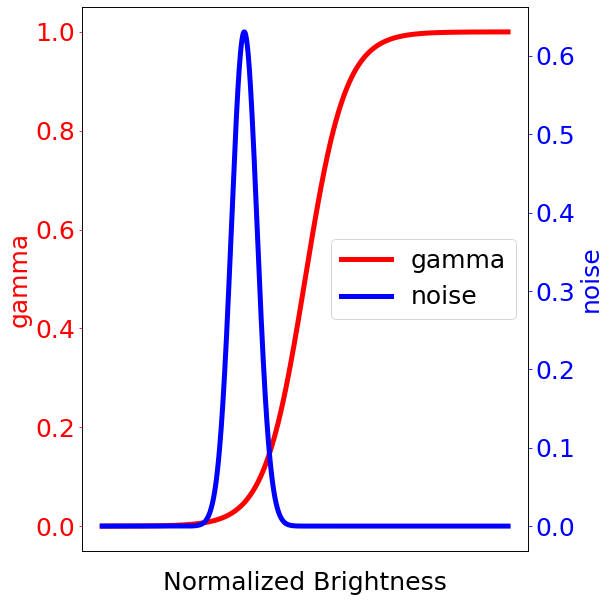

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

mu = -3
variance = 0.4
sigma = math.sqrt(variance)

x = np.linspace(-10, 10, 1000)
y = 1/(1+np.exp(-x))


#plt.figure()
#plt.plot(x, y, label='gamma')
#plt.plot(x, stats.norm.pdf(x, mu, sigma), label='noise')
#plt.xlabel('Brightness')
#plt.ylabel
#plt.show()
plt.figure(figsize=(8, 10))
ax1 = plt.subplot()
l1, = ax1.plot(x, y, color = 'red', linewidth = 5, label='gamma')
ax1.set_ylabel('gamma', fontsize=25)
ax1.yaxis.label.set_color('red')
ax1.tick_params(axis='y', colors='red')
ax1.set_xlabel('Normalized Brightness', labelpad=20, fontsize=25)
ax1.tick_params(labelsize=25)
ax2 = ax1.twinx()
l2, = ax2.plot(x, stats.norm.pdf(x, mu, sigma), color='blue', linewidth = 5, label='noise')
ax2.yaxis.label.set_color('blue')
ax2.tick_params(axis='y', colors='blue', labelsize=25)
ax2.set_ylabel('noise', fontsize=25)
plt.legend([l1, l2], ["gamma", "noise"], loc = 'center right', fontsize=25)
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.show()
#plt.xlabel('Brightness')

### Codes from reference repos

In [15]:
Cell_reccurent = tf.keras.layers.AbstractRNNCell

IFStateTuple = namedtuple('IFStateTuple', ('v', 'z', 'i_future_buffer', 'z_buffer'))

class IF(Cell_reccurent):
    def __init__(self, n_in, n_rec, thr = 0.03, dt = 1.0, n_refractory=0, 
        n_delay = 1, dampening_factor=0.3, dtype=tf.float32, 
        injected_noise_current=0., v0 = 1.):
        '''
            :param n_refractory: number of refractory time steps - refractory time that the neuron cannot be fired again
            :param dtype: data type of the cell tensors
            :param n_delay: number of synaptic delay timestep, the delay range goes from 1 to n_delay time steps
        '''
        if np.isscalar(thr): thr = tf.ones(n_rec, dtype=dtype) * np.mean(thr)
        dt = tf.cast(dt, dtype=dtype)

        self.n_in = n_in
        self.n_rec = n_rec
        self.thr = tf.Variable(thr, dtype=dtype, name="Threshold", trainable=False) 
        self.dt = tf.cast(dt, dtype=dtype)
        self.n_refractory = n_refractory #　number of refractory time steps　—　refractory time that the neuron cannot be fired again
        self.n_delay = n_delay # number of synaptic delay timestep, the delay range goes from 1 to n_delay time steps
        self.dtype = dtype # dtype of neuron tensor
        self.v0 = v0 # initial membrane voltage
        self.dampening_factor = dampening_factor

        self._num_units = self.n_rec
        self.injected_noise_current = injected_noise_current # take device standard deviation into consideration


        # Input weights
        self.w_in_var = tf.Variable(np.random.randn(n_in, n_rec) / np.sqrt(n_in), dtype=dtype, name="InputWeight")
        self.w_in_val = self.w_in_var

        self.w_in_val = self.v0 * self.w_in_val
        # randomize the initial input current weight
        self.w_in_delay = tf.Variable(np.random.randint(self.n_delay, size=n_in * n_rec).reshape(n_in, n_rec),
                                        dtype=tf.int64, name="InDelays", trainable=False) 
        self.W_in = weight_matrix_with_delay_dimension(self.w_in_val, self.w_in_delay, self.n_delay)

        # randomize the initial recurrent current weight
        self.w_rec_var = tf.Variable(np.random.randn(n_rec, n_rec) / np.sqrt(n_rec), dtype=dtype,
                                    name='RecurrentWeight')
        self.w_rec_val = self.w_rec_var

        recurrent_disconnect_mask = np.diag(np.ones(n_rec, dtype=bool))

        self.w_rec_val = self.w_rec_val * self.v0
        self.w_rec_val = tf.where(recurrent_disconnect_mask, tf.zeros_like(self.w_rec_val),
                                    self.w_rec_val)  # Disconnect autotapse
        self.w_rec_delay = tf.Variable(np.random.randint(self.n_delay, size=n_rec * n_rec).reshape(n_rec, n_rec),
                                        dtype=tf.int64, name="RecDelays", trainable=False)
        self.W_rec = weight_matrix_with_delay_dimension(self.w_rec_val, self.w_rec_delay, self.n_delay)

    @property
    def state_size(self):
        return IFStateTuple(v=self.n_rec,
                            z=self.n_rec,
                            i_future_buffer=(self.n_rec, self.n_delay), # create space for future current
                            z_buffer=(self.n_rec, self.n_refractory)) # create space for refractory spike trains

    @property
    def output_size(self):
        return self.n_rec

    def zero_state(self, batch_size, dtype = tf.float32, n_rec=None):
        '''Create the zero state tuple of IF neuron'''
        if n_rec is None: n_rec = self.n_rec

        v0 = tf.zeros(shape=(batch_size, n_rec), dtype=dtype)
        z0 = tf.zeros(shape=(batch_size, n_rec), dtype=dtype)

        i_buff0 = tf.zeros(shape=(batch_size, n_rec, self.n_delay), dtype=dtype)
        z_buff0 = tf.zeros(shape=(batch_size, n_rec, self.n_refractory), dtype=dtype)

        return IFStateTuple(
            v=v0,
            z=z0,
            i_future_buffer=i_buff0,
            z_buffer=z_buff0
        )


    def neuronal_dynamic(self, v, z, z_buffer, i_future_buffer, state=IFStateTuple):
        """
        Function that generate the next spike and voltage tensor for given cell state.
        :param thr - membrane threshold voltage
        :param v - current membrane voltage
        :param z - input spike train from previous layer at time t
        :return: current v, z
        """
        # create current with respect to input current from previous layer and current layer of previous timestep
        add_current = self.W_in * z + self. W_rec * state.z

        # add random noise to current
        if self.injected_noise_current > 0:
            add_current = add_current + tf.random.normal(shape=z.shape, stddev=self.injected_noise_current) 
            
        if thr is None: thr = self.thr
        if n_refractory is None: n_refractory = self.n_refractory

        i_t = i_future_buffer[:, :, 0] + add_current

        I_reset = z * thr * self.dt # thr is fixed for IF/LIF neuron, but changable for ALIF neuron. 

        new_v = v + i_t - I_reset # the membrane voltage at t+dt

        # Spike generation
        v_scaled = (v - thr) / thr

        new_z = SpikeFunction(v_scaled, self.dampening_factor) 

        if n_refractory > 0:
            is_ref = tf.greater(tf.reduce_max(z_buffer[:, :, -n_refractory:], axis=2), 0)
            new_z = tf.where(is_ref, tf.zeros_like(new_z), new_z)

        new_z = new_z * 1 / self.dt

        return new_v, new_z # return the new membrane voltage, and new input spike train

    def __call__(self, inputs, state = IFStateTuple):
        '''Convert the IF neuron to callable object'''
        with tf.name_scope('IFcall'):
            # self.W_in : input current weights
            # self.W_rec : recurrent current weights
            i_future_buffer = state.i_future_buffer + einsum_bi_ijk_to_bjk(inputs, self.W_in) + einsum_bi_ijk_to_bjk(
                state.z, self.W_rec) 

            new_v, new_z = self.neuronal_dynamic(
                v=state.v,
                z=state.z,
                z_buffer=state.z_buffer,
                i_future_buffer=i_future_buffer)

            new_z_buffer = tf_roll(state.z_buffer, new_z, axis=2)
            new_i_future_buffer = tf_roll(i_future_buffer, axis=2)

            new_state = IFStateTuple(v=new_v,
                                     z=new_z,
                                     i_future_buffer=new_i_future_buffer,
                                     z_buffer=new_z_buffer)
        return new_z, new_state

NameError: name 'IFStateTuple' is not defined

**Model**

In [1]:
class   SRNN(tf.keras.Model):
    def __init__(self, input, hidden, output):
        super().__init__()
        self.input = input
        self.hidden = hidden
        self.output = output

    def call(self, inputs):
        x = self.input(inputs)
        x = self.hidden(x)
        return self.output(x)


NameError: name 'tf' is not defined

In [ ]:
LIFStateTuple = namedtuple('LIFStateTuple', ('v', 'z', 'i_future_buffer', 'z_buffer'))

class LIF(IF):
    def __init__(self, n_in, n_rec, thr = 0.03, tau = 20., dt = 1., n_refractory=0, 
                n_delay = 1, in_neuron_sign=None, rec_neuron_sign=None, dtype=tf.float32, dampening_factor=0.3,
                injected_noise_current=0., v0=0.01):
        '''
            :param n_refractory: number of refractory time steps - refractory time that the neuron cannot be fired again
            :param dtype: data type of the cell tensors
            :param n_delay: number of synaptic delay timestep, the delay range goes from 1 to n_delay time steps
        '''
        super(LIF, self).__init__(n_in = n_in, n_rec = n_rec, thr = thr, dt = dt, n_refractory = n_refractory, 
                                  n_delay = n_delay, in_neuron_sign = in_neuron_sign, 
                                  rec_neuron_sign = rec_neuron_sign, dtype = dtype, dampening_factor = dampening_factor,
                                  injected_noise_current = injected_noise_current, v0 = v0)

        if np.isscalar(tau): tau = tf.ones(n_rec, dtype=dtype) * np.mean(tau)
        tau = tf.cast(tau, dtype=dtype)
        
        self.tau = tf.Variable(tau, dtype=dtype, name="Tau", trainable=False)
        self._decay = tf.exp(-dt / tau)

    @property
    def state_size(self):
        return LIFStateTuple(v=self.n_rec,
                             z=self.n_rec,
                             i_future_buffer=(self.n_rec, self.n_delay),
                             z_buffer=(self.n_rec, self.n_refractory))

    def zero_state(self, batch_size, dtype, n_rec=None):
        if n_rec is None: n_rec = self.n_rec

        v0 = tf.zeros(shape=(batch_size, n_rec), dtype=dtype)
        z0 = tf.zeros(shape=(batch_size, n_rec), dtype=dtype)

        i_buff0 = tf.zeros(shape=(batch_size, n_rec, self.n_delay), dtype=dtype)
        z_buff0 = tf.zeros(shape=(batch_size, n_rec, self.n_refractory), dtype=dtype)

        return LIFStateTuple(
            v=v0,
            z=z0,
            i_future_buffer=i_buff0,
            z_buffer=z_buff0
        )

    def __call__(self, inputs, state):
        '''Convert the IF neuron to callable object'''
        with tf.name_scope('LIFcall'):
            i_future_buffer = state.i_future_buffer + einsum_bi_ijk_to_bjk(inputs, self.W_in) + einsum_bi_ijk_to_bjk(
                state.z, self.W_rec) # self.W_in and self.W_rec need to consider

            new_v, new_z = self.neuronal_dynamic(
                v=state.v,
                z=state.z,
                z_buffer=state.z_buffer,
                i_future_buffer=i_future_buffer)

            new_z_buffer = tf_roll(state.z_buffer, new_z, axis=2)
            new_i_future_buffer = tf_roll(i_future_buffer, axis=2)

            new_state = LIFStateTuple(v=new_v,
                                      z=new_z,
                                      i_future_buffer=new_i_future_buffer,
                                      z_buffer=new_z_buffer)
        return new_z, new_state

    def neuronal_dynamic(self, v, z, z_buffer, i_future_buffer, thr=None, decay=None, n_refractory=None, add_current=0.):

        if self.injected_noise_current > 0:
            add_current = tf.random.normal(shape=z.shape, stddev=self.injected_noise_current) # add random noise to current

        if thr is None: thr = self.thr
        if decay is None: decay = self._decay
        if n_refractory is None: n_refractory = self.n_refractory

        i_t = i_future_buffer[:, :, 0] + add_current

        I_reset = z * thr * self.dt # thr is fixed for LIF neuron, but changable for ALIF neuron. 

        new_v = decay * v + (1 - decay) * i_t - I_reset # the membrane voltage at t+dt

        # Spike generation
        v_scaled = (v - thr) / thr

        new_z = SpikeFunction(v_scaled, self.dampening_factor) # update the z value

        if n_refractory > 0:
            is_ref = tf.greater(tf.reduce_max(z_buffer[:, :, -n_refractory:], axis=2), 0)
            new_z = tf.where(is_ref, tf.zeros_like(new_z), new_z)

        new_z = new_z * 1 / self.dt

        return new_v, new_z # return the new membrane voltage, and new input spike train

In [ ]:
ALIFStateTuple = namedtuple('ALIFStateTuple', ('v', 'z', 'b', 'i_future_buffer', 'z_buffer'))

class ALIF(LIF):
    def __init__(self, n_in, n_rec, tau=20, thr=0.01,
                 dt=1., n_refractory=0, dtype=tf.float32, n_delay=1,
                 tau_adaptation=200., beta=1.6, dampening_factor=0.3,
                 in_neuron_sign=None, rec_neuron_sign=None, injected_noise_current=0.,
                 v0=0.01):
        """
        Tensorflow cell object that simulates a LIF neuron with an approximation of the spike derivatives.

        :param n_in: number of input neurons
        :param n_rec: number of recurrent neurons
        :param tau: membrane time constant
        :param thr: threshold voltage
        :param dt: time step of the simulation
        :param n_refractory: number of refractory time steps
        :param dtype: data type of the cell tensors
        :param n_delay: number of synaptic delay, the delay range goes from 1 to n_delay time steps
        :param tau_adaptation: adaptation time constant for the threshold voltage
        :param beta: amplitude of adpatation
        :param in_neuron_sign: vector of +1, -1 to specify input neuron signs
        :param rec_neuron_sign: same of recurrent neurons
        :param injected_noise_current: amplitude of current noise
        :param V0: to choose voltage unit, specify the value of V0=1 Volt in the desired unit (example V0=1000 to set voltage in millivolts)
        """

        super(ALIF, self).__init__(n_in=n_in, n_rec=n_rec, tau=tau, thr=thr, dt=dt, n_refractory=n_refractory,
                                   n_delay=n_delay, dampening_factor=dampening_factor, in_neuron_sign=in_neuron_sign,
                                   rec_neuron_sign=rec_neuron_sign,
                                   injected_noise_current=injected_noise_current,
                                   v0=v0, dtype=dtype)

        if tau_adaptation is None: raise ValueError("alpha parameter for adaptive bias must be set")
        if beta is None: raise ValueError("beta parameter for adaptive bias must be set")

        self.tau_adaptation = tf.Variable(tau_adaptation, dtype=dtype, name="TauAdaptation", trainable=False)

        self.beta = tf.Variable(beta, dtype=dtype, name="Beta", trainable=False)
        self.decay_b = np.exp(-dt / tau_adaptation)

    @property
    def output_size(self):
        return [self.n_rec, self.n_rec, self.n_rec]

    @property
    def state_size(self):
        return ALIFStateTuple(v=self.n_rec,
                              z=self.n_rec,
                              b=self.n_rec,
                              i_future_buffer=(self.n_rec, self.n_delay),
                              z_buffer=(self.n_rec, self.n_refractory))

    def zero_state(self, batch_size, dtype, n_rec=None):
        if n_rec is None: n_rec = self.n_rec

        v0 = tf.zeros(shape=(batch_size, n_rec), dtype=dtype)
        z0 = tf.zeros(shape=(batch_size, n_rec), dtype=dtype)
        b0 = tf.zeros(shape=(batch_size, n_rec), dtype=dtype)

        i_buff0 = tf.zeros(shape=(batch_size, n_rec, self.n_delay), dtype=dtype)
        z_buff0 = tf.zeros(shape=(batch_size, n_rec, self.n_refractory), dtype=dtype)

        return ALIFStateTuple(
            v=v0,
            z=z0,
            b=b0,
            i_future_buffer=i_buff0,
            z_buffer=z_buff0
        )

    def __call__(self, inputs, state):
        with tf.name_scope('ALIFcall'):
            i_future_buffer = state.i_future_buffer + einsum_bi_ijk_to_bjk(inputs, self.W_in) + einsum_bi_ijk_to_bjk(
                state.z, self.W_rec)

            new_b = self.decay_b * state.b + (1. - self.decay_b) * state.z

            thr = self.thr + new_b * self.beta * self.V0

            new_v, new_z = self.neuronal_dynamic(
                v=state.v,
                z=state.z,
                z_buffer=state.z_buffer,
                i_future_buffer=i_future_buffer,
                decay=self._decay,
                thr=thr)

            new_z_buffer = tf_roll(state.z_buffer, new_z, axis=2)
            new_i_future_buffer = tf_roll(i_future_buffer, axis=2)

            new_state = ALIFStateTuple(v=new_v,
                                       z=new_z,
                                       b=new_b,
                                       i_future_buffer=new_i_future_buffer,
                                       z_buffer=new_z_buffer)
        return [new_z, new_v, thr], new_state


    def static_rnn_with_gradient(cell, inputs, state, loss_function, T, verbose=True):
        batch_size = tf.shape(inputs)[0]

        thr_list = []
        state_list = []
        z_list = []
        v_list = []

        if verbose: print('Building forward Graph...', end=' ')
        t0 = time()
        for t in range(T):
            outputs, state = cell(inputs[:, t, :], state)
            z, v, thr = outputs

            z_list.append(z)
            v_list.append(v)
            thr_list.append(thr)
            state_list.append(state)

        zs = tf.stack(z_list, axis=1)
        vs = tf.stack(v_list, axis=1)
        thrs = tf.stack(thr_list, axis=1)
        loss = loss_function(zs)

        de_dz_partial = tf.gradients(loss, zs)[0]
        if de_dz_partial is None:
            de_dz_partial = tf.zeros_like(zs)
            print('Warning: Partial de_dz is None')
        print('Done in {:.2f}s'.format(time() - t0))

        def namedtuple_to_list(state):
            return list(state._asdict().values())

        zero_state_as_list = cell.zero_state(batch_size, tf.float32)
        de_dstate = namedtuple_to_list(cell.zero_state(batch_size, dtype=tf.float32))
        g_list = []
        if verbose: print('Building backward Graph...', end=' ')
        t0 = time()
        for t in np.arange(T)[::-1]:

            # gradient from next state
            if t < T - 1:
                state = namedtuple_to_list(state_list[t])
                next_state = namedtuple_to_list(state_list[t + 1])
                de_dstate = tf.gradients(ys=next_state, xs=state, grad_ys=de_dstate)

                for k_var, de_dvar in enumerate(de_dstate):
                    if de_dvar is None:
                        de_dstate[k_var] = tf.zeros_like(zero_state_as_list[k_var])
                        print('Warning: var {} at time {} is None'.format(k_var, t))

            # add the partial derivative due to current error
            de_dstate[0] = de_dstate[0] + de_dz_partial[:, t]
            g_list.append(de_dstate[0])

        g_list = list(reversed(g_list))

        gs = tf.stack(g_list, axis=1)
        print('Done in {:.2f}s'.format(time() - t0))

        return zs, vs, thrs, gs, state_list[-1]

## Part 2 - **Weight_Update_Methods.py**
A py file that contains all the weight update methods.

    - Back propagation through time (BPTT) for RNN
    - Spike timing depedent plasticity (STDP)

### BPTT

In [ ]:
def static_rnn_with_gradient(cell, inputs, state,  T, loss=tf.keras.losses.SparseCategoricalCrossentropy, verbose=True):
    '''Calculate the gradient'''
    batch_size = tf.shape(inputs)[0]

    thr_list = []
    state_list = []
    z_list = []
    v_list = []

    if verbose: print('Building forward Graph...', end=' ')
    t0 = time()
    for t in range(T):
        outputs, state = cell(inputs[:, t, :], state)
        z, v, thr = outputs

        z_list.append(z)
        v_list.append(v)
        thr_list.append(thr)
        state_list.append(state)

    zs = tf.stack(z_list, axis=1)
    vs = tf.stack(v_list, axis=1)
    thrs = tf.stack(thr_list, axis=1)
    loss = loss(zs)

    de_dz_partial = tf.gradients(loss, zs)[0]
    if de_dz_partial is None:
        de_dz_partial = tf.zeros_like(zs)
        print('Warning: Partial de_dz is None')
    print('Done in {:.2f}s'.format(time() - t0))

    def namedtuple_to_list(state):
        return list(state._asdict().values())

    zero_state_as_list = cell.zero_state(batch_size, tf.float32)
    de_dstate = namedtuple_to_list(cell.zero_state(batch_size, dtype=tf.float32))
    g_list = []
    if verbose: print('Building backward Graph...', end=' ')
    t0 = time()
    for t in np.arange(T)[::-1]:

        # gradient from next state
        if t < T - 1:
            state = namedtuple_to_list(state_list[t])
            next_state = namedtuple_to_list(state_list[t + 1])
            de_dstate = tf.gradients(ys=next_state, xs=state, grad_ys=de_dstate)

            for k_var, de_dvar in enumerate(de_dstate):
                if de_dvar is None:
                    de_dstate[k_var] = tf.zeros_like(zero_state_as_list[k_var])
                    print('Warning: var {} at time {} is None'.format(k_var, t))

        # add the partial derivative due to current error
        de_dstate[0] = de_dstate[0] + de_dz_partial[:, t]
        g_list.append(de_dstate[0])

    g_list = list(reversed(g_list))

    gs = tf.stack(g_list, axis=1)
    print('Done in {:.2f}s'.format(time() - t0))

    return zs, vs, thrs, gs, state_list[-1]

### Modified_STDP

In [ ]:
def Modified_STDP_weight_update(ratio, G_min, G_max, current_weight, 
                       alpha_p, alpha_m, beta_p, beta_m, potentiation = 1):
    
    '''
    Inputs:
        ratio: true_update_ratio/calculated_update_ratio by exponential funcion
        G_min: minimum conductance of a device
        G_max: maximum conductance of a device
        current_weight: current weight matrix
        alpha_p: alpha index for potentiation
        alpha_m: alpha index for depression 
        beta_p: beta index for potentiation
        beta_m: beta index for depression
        t1: fired time of pre-synaptic neuron
        t2: fired time of post-synaptic neuron
    Return:
        updated_weights
    '''
    if potentiation == 1: # for the case of potentiation
        delta_weight = alpha_p * np.exp(-beta_p*(current_weight-G_min)/(G_max-G_min))
        updated_weight = current_weight + delta_weight * ratio

    elif potentiation == 0: # for the case of depression
        delta_weight = -alpha_m * np.exp(-beta_m*(G_max-current_weight)/(G_max-G_min))
        updated_weight = current_weight + delta_weight * ratio
    else:
        raise ValueError("Parameter potentiation must be 0 or 1!")

    return updated_weight

# calculate the change of weight/conductance with respect to z_pre and z_rec
def Modified_update_weight(w_in, z_pre, z_rec, G_min, G_max, alpha_p, alpha_m, beta_p, beta_m, ratios):
    '''For arbitrary spike trains - z_pre and z_rec, update the weight''' 
    assert (len(z_pre) == len(z_rec)), "two input spike trains should have the same length."
    w_in_history = []
    for i in range(len(z_pre)-1):
        if z_pre[i] != 0:
            if z_rec[i-1] != 0: #　depression
                w_in = Modified_STDP_weight_update(ratios[i], G_min, G_max, w_in, alpha_p, alpha_m, beta_p, beta_m, 0)
            elif z_rec[i+1] != 0: # potentiation
                w_in = Modified_STDP_weight_update(ratios[i], G_min, G_max, w_in, alpha_p, alpha_m, beta_p, beta_m, 1)
        w_in_history.append(w_in)
    return w_in_history


### Model

In [ ]:
RNN = tf.keras.layers.RNN()

class Spiking_Layer(RNN):
    def __init__(self, Cell, return_sequences=False, return_state=False):
        '''
            :param Cell: type of recurrent cell, either ALIF or LIF.
            :param return_sequences
            :param return_state
        '''
        self.Cell = Cell
        self.return_sequences = return_sequences
        self.return_state = return_state

    def get_shape():
        return Cell.shape()

    
        

class Spiking_model(tf.keras.Model):
    def __init__(self, input, hidden, output, G_min, G_max, ratios,
                       alpha_p, alpha_m, beta_p, beta_m, weights_init = 0.5):
        super().__init__()
        # model structures
        self.input = input
        self.hidden = hidden
        self.output = output

        # STDP parameters
        self.G_min = G_min
        self.G_max = G_max
        self.alpha_p = alpha_p
        self.alpha_m = alpha_m
        self.beta_p = beta_p
        self.beta_m = beta_m
        self.ratios = ratios

        # initial weights
        self.weights = [weights_init * np.ones([input.get_shape(), hidden.get_shape()]),
                        weights_init * np.ones([hidden.get_shape(), input.get_shape()])]
      

    def call(self, x, STDP=True):
        '''feed-forward function for the model'''
        hidden_input_val = self.input(x)
        if STDP==True:
            self.weights = Modified_STDP_weight_update(self.ratios, self.G_min, self.G_max, self.weights, 
                       self.alpha_p, self.alpha_m, self.beta_p, self.beta_m)
        
        output_input_val = self.output(hidden_input_val)
        return self.output(output_input_val)

    def calculate_loss(self, x, y_true, loss_func):
        y_pred = self.call(x, STDO=True)
        return loss_func(y_pred, y_true)

    def fit(self, x, y_true, loss_func):
        # calculate the loss
        loss = self.calculate_loss(x, y_true, loss_func)

        # calculate the derivative

        # Conduct BPTT through time
        




    @property
    def state_size(self):
        return IFStateTuple(v=self.n_rec,
                            z=self.n_rec,
                            i_future_buffer=(self.n_rec, self.n_delay), # create space for future current
                            z_buffer=(self.n_rec, self.n_refractory)) # create space for refractory spike trains

    @property
    def output_size(self):
        return self.n_rec

    def zero_state(self, batch_size, dtype = tf.float32, n_rec=None):
        '''Create the zero state tuple of IF neuron'''
        if n_rec is None: n_rec = self.n_rec

        v0 = tf.zeros(shape=(batch_size, n_rec), dtype=dtype)
        z0 = tf.zeros(shape=(batch_size, n_rec), dtype=dtype)

        i_buff0 = tf.zeros(shape=(batch_size, n_rec, self.n_delay), dtype=dtype)
        z_buff0 = tf.zeros(shape=(batch_size, n_rec, self.n_refractory), dtype=dtype)

        return IFStateTuple(
            v=v0,
            z=z0,
            i_future_buffer=i_buff0,
            z_buffer=z_buff0
        )
    

# **Main function for sMNIST**

- (Partially Done) Define some constants
- (Done) Generate spike trains from images
- (TODO) Define the model
- (TODO) Fit the model by STDP and BPTT
- (TODO) Calculate the accuracy

In [ ]:
import tensorflow as tf
import numpy as np
import pickle, gzip


# (TODO) - Step 1: define some constants

# Constants for the model
input_n = tf.constant(80)
input_exitatory_n = tf.constant(60)
input_inhibitary_n = tf.constant(20)
hidden_n = tf.constant(220)
hidden_LIF_n = tf.constant(120)
hidden_ALIF_n = hidden_n - hidden_LIF_n
output_n = tf.constant(10)
print("Please specify the type of model (ALIF/LIF).")
model = tf.string(str(input(" Model: ")))

# Constants for training and testing
print("Please specify the constants for STDP weight update.")

training_size = tf.constant(int(input(" Training size: ")))
test_size = tf.constant(int(input(" Test size: ")))
dampening_factor = 0.3 # dampening factor for pseudo gradient

# Constants for STDP
print("Please specify the constants for STDP weight update.")

# potentiation
alpha_p = tf.constant(float(input(" alpha_p: ")))
beta_p = tf.constant(float(input(" beta_p: ")))

# depression
alpha_m = tf.constant(float(input(" alpha_m: ")))
beta_m = tf.constant(float(input(" beta_m: ")))

# device parameters
G_max = tf.constant(float(input(" G_max: ")))
G_min = tf.constant(float(input(" G_min: ")))

# time constants
t0 = 0 # initial time as 0
dt = 1 # timestep from  NIPS 2018

# ALIF/LIF neuron constants
tau_v = 20 # time constant for voltage changing from NIPS 2018
tau_a = 700 # time constant for adaptive threshold from NIPS 2018
thr = 0.1 # baseline threshold of ALIF neuron/threshold of LIF neuron
beta = 1.8 # Scaling constant of the adaptive threshold
n_delay = 10 # maximum synaptic delay
n_ref = 5 # number of refractory steps
v0 = 0.0 # membrane voltage at 0 timestep
dtype = tf.float32 # datatype of parameters inside neurons

In [ ]:
# Step 2: read in the MNIST images and convert them to spike trains
def load_training_set(mnist_directory, training_size):
    """
    Load the MNIST digits for training. Shuffles them as well.

    Inputs: 
        mnist_directory - string: the directory to store MNIST dataset
        training_size - int : the size of training size
    Return:
        training_set - np.array: training_set of randomly selected images from MNIST with size of training_size
    """
    # Sanity checks
    assert(type(mnist_directory) == str), "Parameter mnist_directory must be a string!"
    assert(type(training_size) == int), "Parameter training_size must be an int!"
    assert(training_size >=0 and training_size <= 60000), "Parameter training_size must >= 0 and <= 60000!"

    print("Loading MNIST for training (randomized)...")
    
    # Update global training_set variable
    global training_set
    
    # Open MNIST pickle package
    f = gzip.open(mnist_directory, 'rb')
    
    # load sets using pickle
    # encoding necessary since pickle file was created in python 2.7
    train, valid, _ = pickle.load(f,encoding='latin1')
    
    # split up into corresponding sets
    [training_set, _] = train
    [validation_set, _] = valid
    
    # update training set
    training_set = np.concatenate((training_set, validation_set))
    
    # close MNIST file
    f.close()
    
    # randomize loaded MNIST set
    np.random.shuffle(training_set)

    #random_index = np.random.choice(training_set)
    random_index = np.random.choice(training_set.shape[0],training_size,replace=False)
    training_set = training_set[random_index]
    
    print("Done!")

    return training_set


# Reference repo: 
# https://github.com/intel-nrc-ecosystem/models/blob/master/nxsdk_modules_ncl/lsnn/tutorials/smnist_tutorial.ipynb
# Part: Encoding the images into spikes
# spike encoding example
def find_onset_offset(y, threshold):
    """
    Given the input signal y with samples,
    find the indices where y increases and descreases through the value threshold.
    Return stacked binary arrays of shape y indicating onset and offset threshold crossings.
    y must be 1-D numpy arrays.
    """
    # Sanity check
    #assert (len(np.array(threshold)) == 1), "The length of threshold should be 1!"

    if threshold == 255:
        equal = y == threshold
        transition_touch = np.where(equal)[0]
        touch_spikes = np.zeros_like(y)
        touch_spikes[transition_touch] = 1
        return np.expand_dims(touch_spikes, axis=0)
    else:
        # Find where y crosses the threshold (increasing).
        lower = y < threshold
        higher = y >= threshold
        transition_onset = np.where(lower[:-1] & higher[1:])[0]
        transition_offset = np.where(higher[:-1] & lower[1:])[0]
        onset_spikes = np.zeros_like(y)
        offset_spikes = np.zeros_like(y)
        onset_spikes[transition_onset] = 1
        offset_spikes[transition_offset] = 1

    return np.stack((onset_spikes, offset_spikes))


def generate_spike_train_from_image(image, n_inputs = 80):
    """Generate spike trains from an given image.
    Input:
        image: a numpy array that represent pixels of an image
        n_inputs: number of input neurons.
        n_thresholds: number of thresholds for the input layer.
                      should be around half of the number of input neurons. 
    Output
        spike_train_image: spike train of a given image
    """
    # Sanity check
    assert(type(image) == np.ndarray), "Parameter image should be a np.array!"
    assert(type(n_inputs) == int), "Parameter n_inputs should be an int!"

    # turn the image into a 1D array
    image = image.reshape(-1, 1)

    thresholds = np.linspace(0, 255, n_inputs // 2)

    spike_train_image = []
    for pixel in image:  # shape img = (784)
        Sspikes = None
        for thr in thresholds:
            if Sspikes is not None:
                Sspikes = np.concatenate((Sspikes, find_onset_offset(pixel, thr)))
            else:
                Sspikes = find_onset_offset(pixel, thr)
        Sspikes = np.array(Sspikes)  # shape Sspikes = (31, 784)
        Sspikes = np.swapaxes(Sspikes, 0, 1)
        spike_train_image.append(Sspikes)
    spike_train_image = np.array(spike_train_image)
    # add output cue neuron, and expand time for two image rows (2*28)
    out_cue_duration = 2*28 # 56 timesptes to mark the end of encoding an image
    spike_train_image = np.lib.pad(spike_train_image, ((0, 0), (0, out_cue_duration), (0, 1)), 'constant')
    # output cue neuron fires constantly for these additional recall steps
    spike_train_image[:, -out_cue_duration:, -1] = 1

    return spike_train_image

def image_process_pipeline(mnist_directory, training_size):
    training_set = load_training_set(mnist_directory, training_size)
    spike_trains_training_set = []
    for image in training_set:
        spike_trains_training_set.append(generate_spike_train_from_image(image))

    return np.array(spike_trains_training_set)

In [ ]:
# (TODO) - Step 3: define the model

# Define the model
if model == 'LIF': # for LIF model
    beta = np.concatenate([np.zeros(hidden_n)])
    cell = LIF(n_in=input_n, n_rec=hidden_n, thr=thr, tau=tau_v, dt=dt, n_refractory=n_ref, 
               n_delay = n_delay, dampening_factor=dampening_factor, v0 = v0)
elif model == 'ALIF': # for ALIF model
    beta = np.concatenate([np.zeros(hidden_LIF_n), np.ones(hidden_ALIF_n) * beta])
    cell = ALIF(n_in=input_n, n_rec=hidden_n, tau=tau_v, thr=thr,
                 dt=dt, n_refractory=n_ref, dtype=dtype, n_delay=n_delay,
                 tau_adaptation=tau_a, beta=beta, dampening_factor=dampening_factor, v0=v0)
else:
     raise NotImplementedError("Unknown model: " + model)

#input_pixels = tf.compat.v1.placeholder(dtype=tf.float32, shape=(None, None, input_n),
                             # name='InputSpikes')  # MAIN input spike placeholder

#targets = tf.compat.v1.placeholder(dtype=tf.int64, shape=(None,),
 #                        name='Targets')  # Lists of target characters of the recall task

outputs, final_state = tf.keras.layers.RNN(cell, return_sequences=True, return_state=True)

if model == 'ALIF':
    z, v, b = outputs
else:
    z = outputs

# (TODO) - Step 4: fit the model
# (TODO) - Step 5: test and calculate the accuracy  